In [1]:
import sys
import pandas as pd
from datatransformer import DataTransformerDeep
sys.path.insert(0, 'C:/Udvikler/Speciale/SpecialeKode')
from utils import *
import itertools
from model_evaluation.RFQModelEval import RFQModelEval, eval_utils
from DeepRFQAgent import DeepRFQAgent

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

#Not to make the kernel crash
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
def train_loop(train_df, val_df):
    all_features = [
        #["DealersInCompetition", "FirmAccount", "IssuedAmount", "Oas", "BidAskSpread", "Side", "BookName", "KeyRatioPrice", "AllQMinMid", "AllQMaxMid", "AllQMeanMid", "MarketThicknes"],
        #["DealersInCompetition", "FirmAccount", "Side", "BookName", "AllQMeanMid", "Oas", "IssuedAmount"],
        #["FirmAccount", "Oas", "BookName", "AllQMeanMid"],
        #["DealersInCompetition", "BookName",  "AllQMeanMid"],
        #["DealersInCompetition", "FirmAccount", "BookName", "AllQMeanMid"],
        #["FirmAccount", "Oas", "BookName", "Amount", "AllQMeanMid"],
        ["inventoryRisk", "FirmAccount", "Oas", "BookName", "AllQMeanMid"],
        ["bpv_risk", "FirmAccount", "Oas", "BookName", "AllQMeanMid"],
        ["KeyRatioPrice", "BookName", "AllQMeanMid"],
        #["bpv_risk", "DealersInCompetition", "BookName", "AllQMeanMid", "Mid"], Glem mid, giver ingenting!
        ["bpv_risk", "DealersInCompetition", "BookName", "AllQMeanMid"]
    ]

    all_reward_functions = [
        #simpleSpreadReward,
        linearMarginReward,
        quadraticMarginReward,
        #inventory_PnL_reward
    ]

    learning_algorithms = [
        #'MBQ',
        #'BCQ',
        'CQL',
        #'CQL_MarkovGame',
        #'FQI' 

    ]

    metrics = ["dealerHitRate", "mlHitRate", "MLWinShare", "mlDistToCoverMean", "mlDistToCoverStd", "dealerDistToCoverMean", 
            "meanMLProfit", "meanDealerProfit", "meanRLReward", "dealerD2TargetMean", "MLD2TargetMean", "MLD2TargetStd",
            "meanMLSharpeRatio", "meanDealerSharpeRatio"]

    # Convert each list of features to a single concatenated string
    all_features_str = [",".join(features) for features in all_features]  # Join list of strings with commas

    # Create a MultiIndex for the DataFrame using the combinations of parameters
    index = pd.MultiIndex.from_tuples(
        [(features, reward_function.__name__, learning_algorithm)
        for features, reward_function, learning_algorithm in itertools.product(all_features_str, all_reward_functions, learning_algorithms)],
        names=["Features", "Reward Function", "Learning Algorithm"]
    )

    # Initialize an empty DataFrame with the MultiIndex
    results_df = pd.DataFrame(columns=metrics, index=index)

    # Iterate over all combinations and collect results
    for features, reward_function, learning_algorithm in itertools.product(all_features, all_reward_functions, learning_algorithms):
        # Convert features list to a single string
        features_key = ",".join(features)  # Join list of strings with commas
        key = (features_key, reward_function.__name__, learning_algorithm)

        print(f"Combination: {key} \n")
        
        opponent_actions = learning_algorithm in ["CQL_MarkovGame"] 
        discretize_actions = False if learning_algorithm == "BCQ" else True

        # Perform the experiment (replace with your actual code)
        data_transformer = DataTransformerDeep(
            input_features=features, lower_spread_limit=-0.005, upper_spread_limit=0.15,
            reward_function=reward_function, opponent_actions=opponent_actions, discretize_actions=discretize_actions)
        
        agent = DeepRFQAgent(data_transformer=data_transformer)
        agent.train(train_df.copy(), algorithm=learning_algorithm, num_train_steps=2000, follow_progress=False)

        modelEvaluator = RFQModelEval(agent)
        modelPerformance = modelEvaluator.eval(val_df.copy(), algorithm=learning_algorithm, print_post_trade=False, print_violin_plot=False)
        
        # Collect and store the relevant metrics
        results_df.loc[key] = modelPerformance[metrics]  # Example of storing mean values

    # Display the results DataFrame
    print(results_df)
    eval_utils.visualize_trader_vs_ML_metrics(results_df=results_df.copy())
    eval_utils.convex_hull(results_df.copy(), distance_measure="Target")

Results for ISIN DK0009507931, counts: 253
Combination: ('inventoryRisk,FirmAccount,Oas,BookName,AllQMeanMid', 'linearMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=12, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=140, out_features=155, bias=True)
)
Combination: ('inventoryRisk,FirmAccount,Oas,BookName,AllQMeanMid', 'quadraticMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=12, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=140, out_features=155, bias=True)
)
Combination: ('bpv_risk,FirmAccount,Oas,BookName,AllQMeanMid', 'linearMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=12, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=140, out_features=155, bias=True)
)
Co

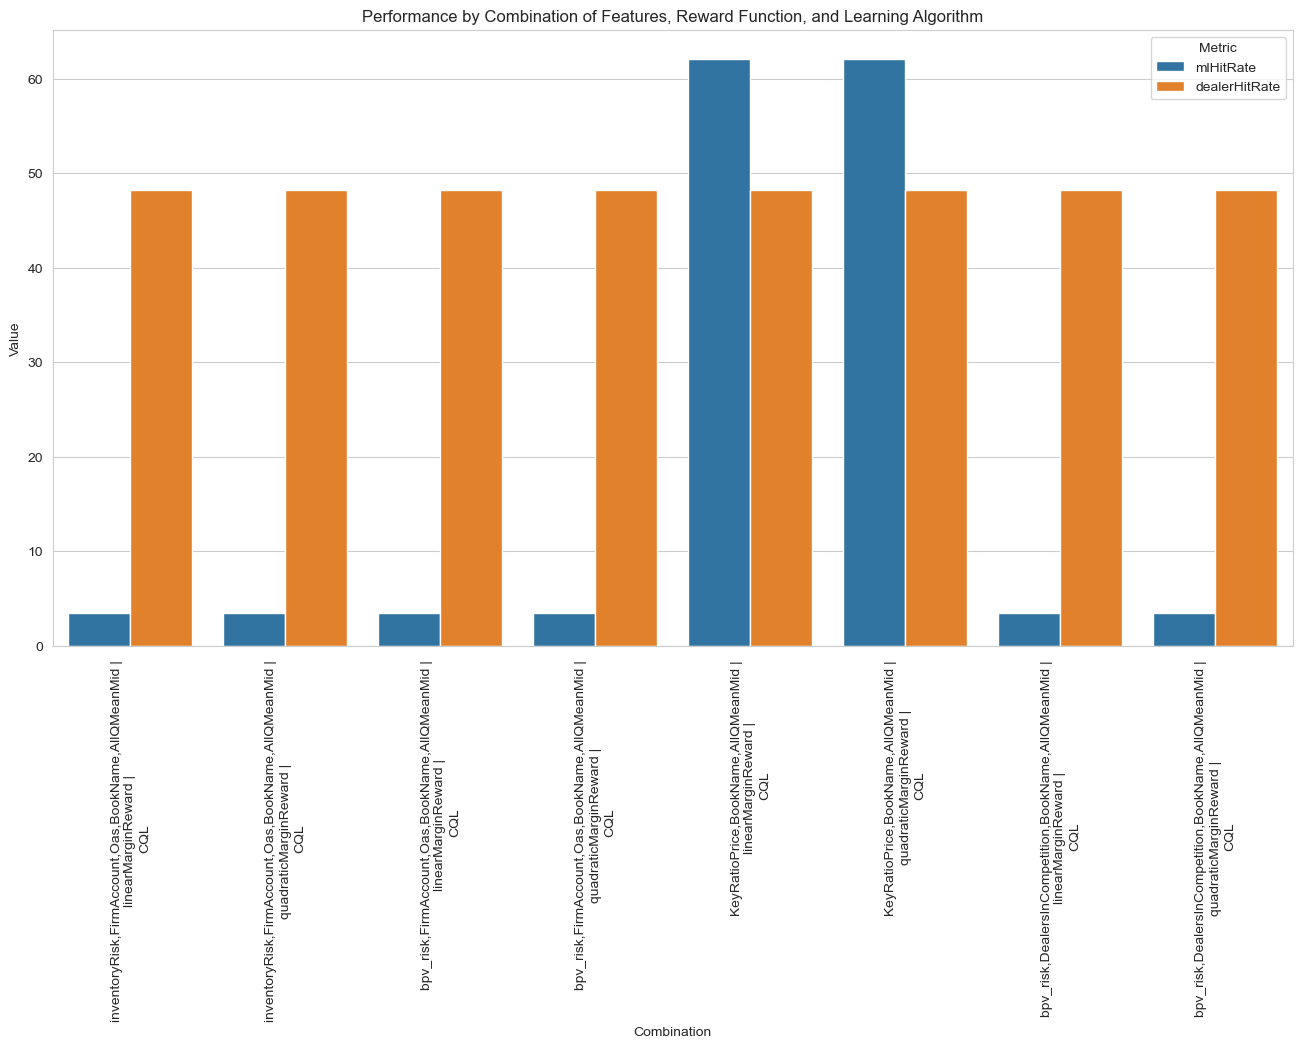

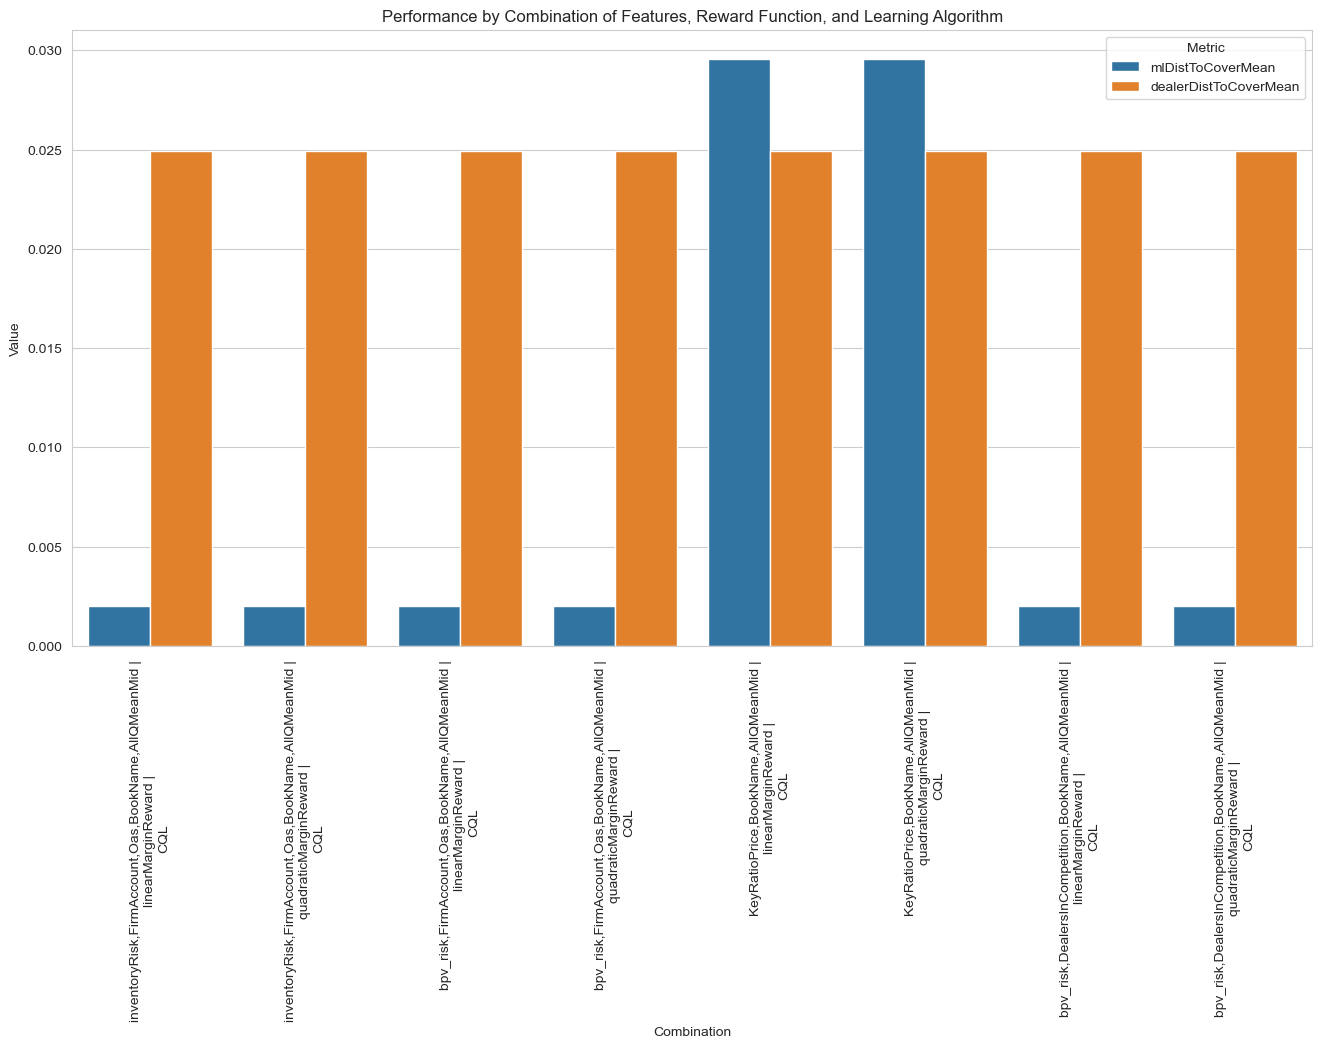

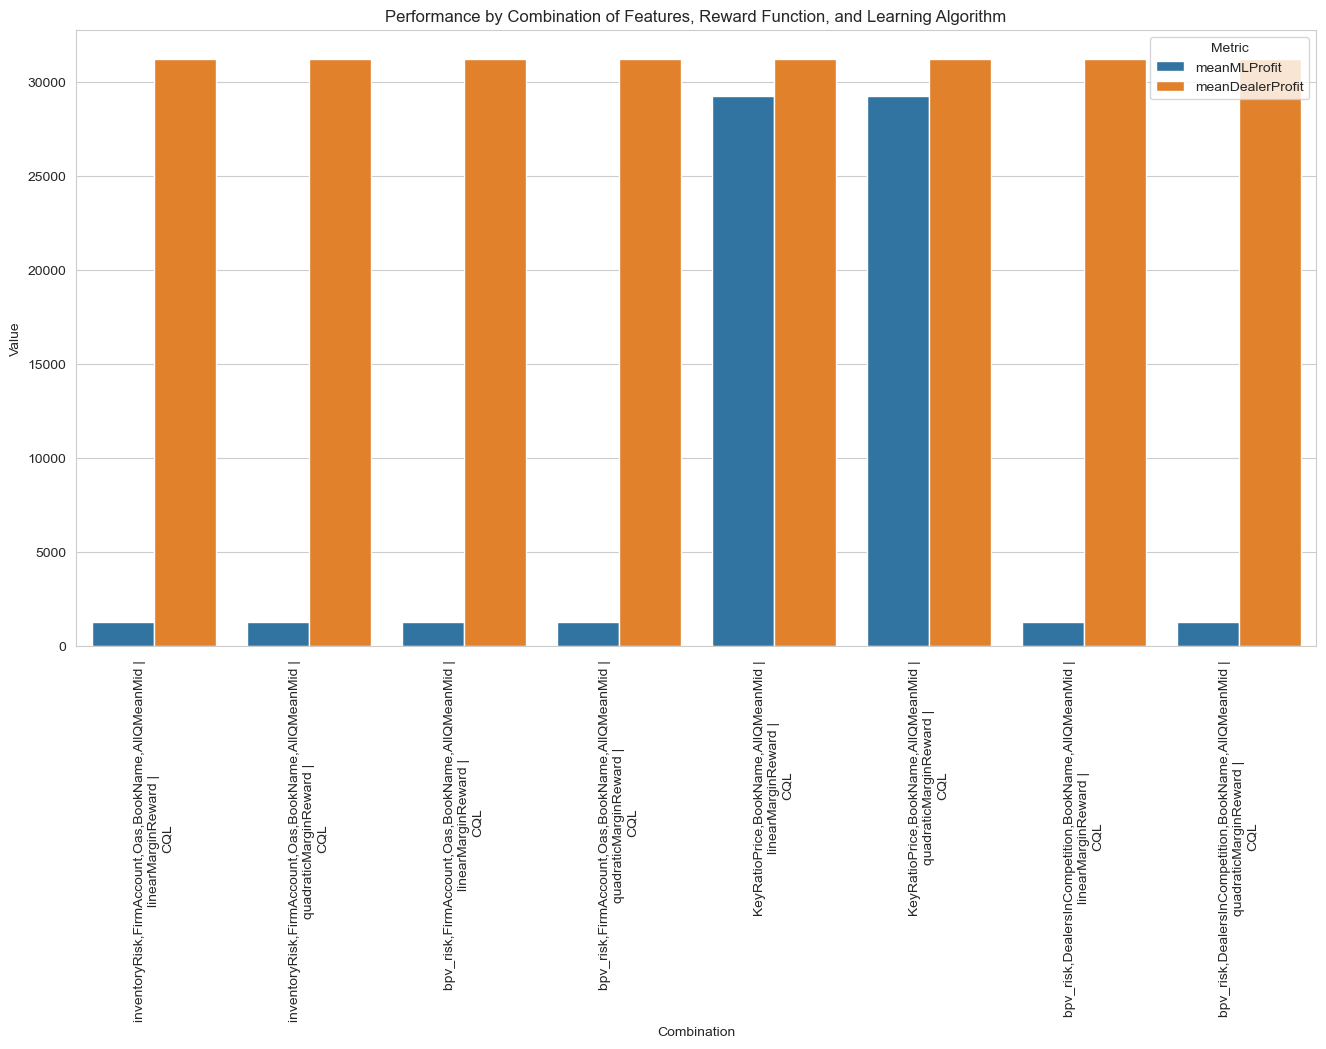

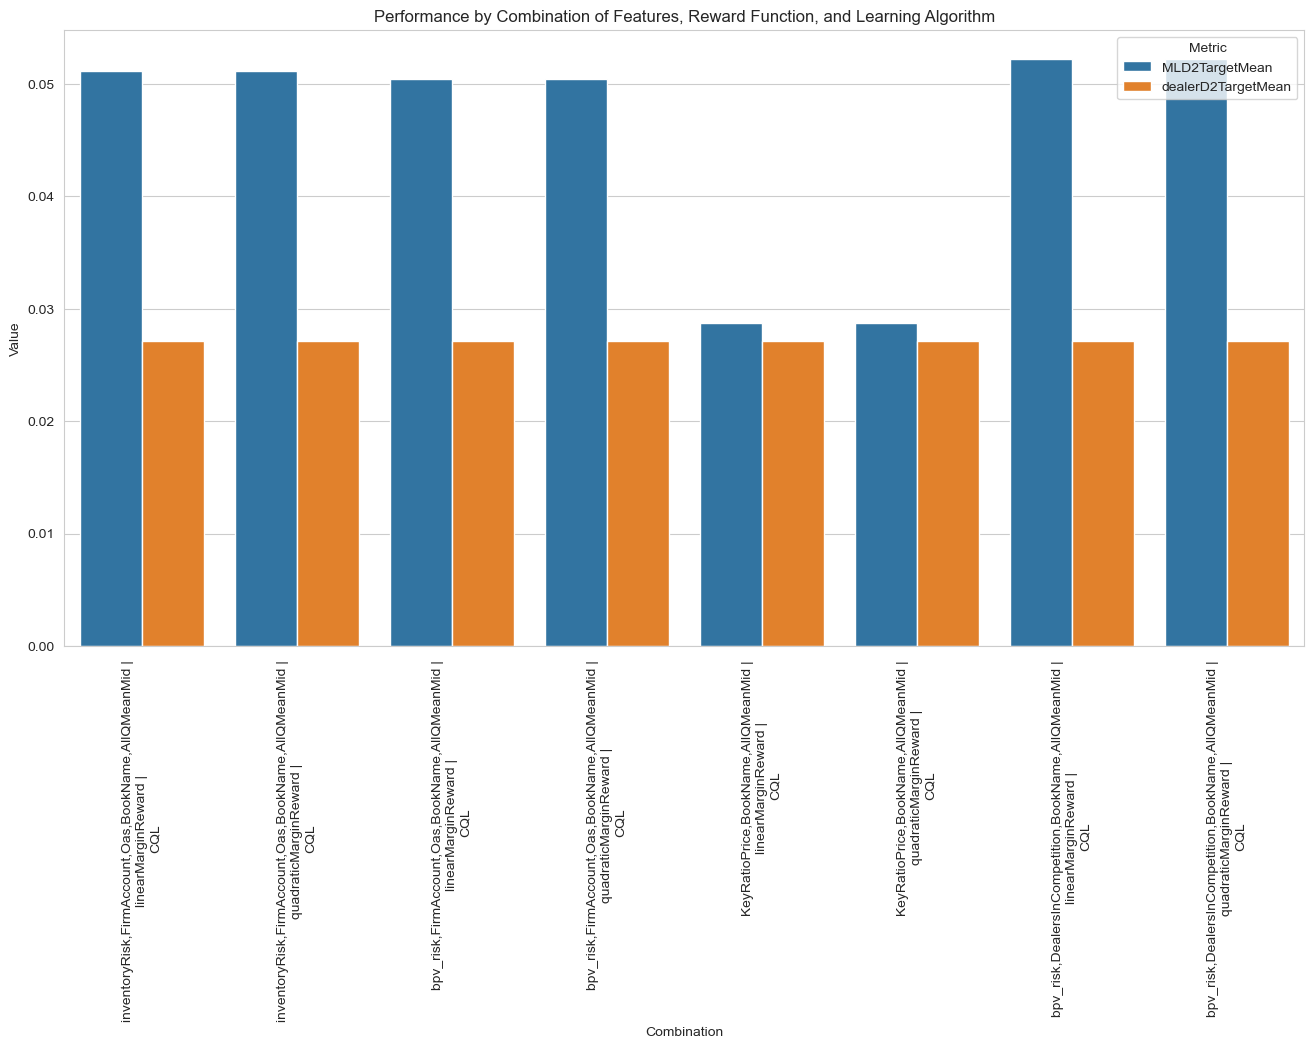

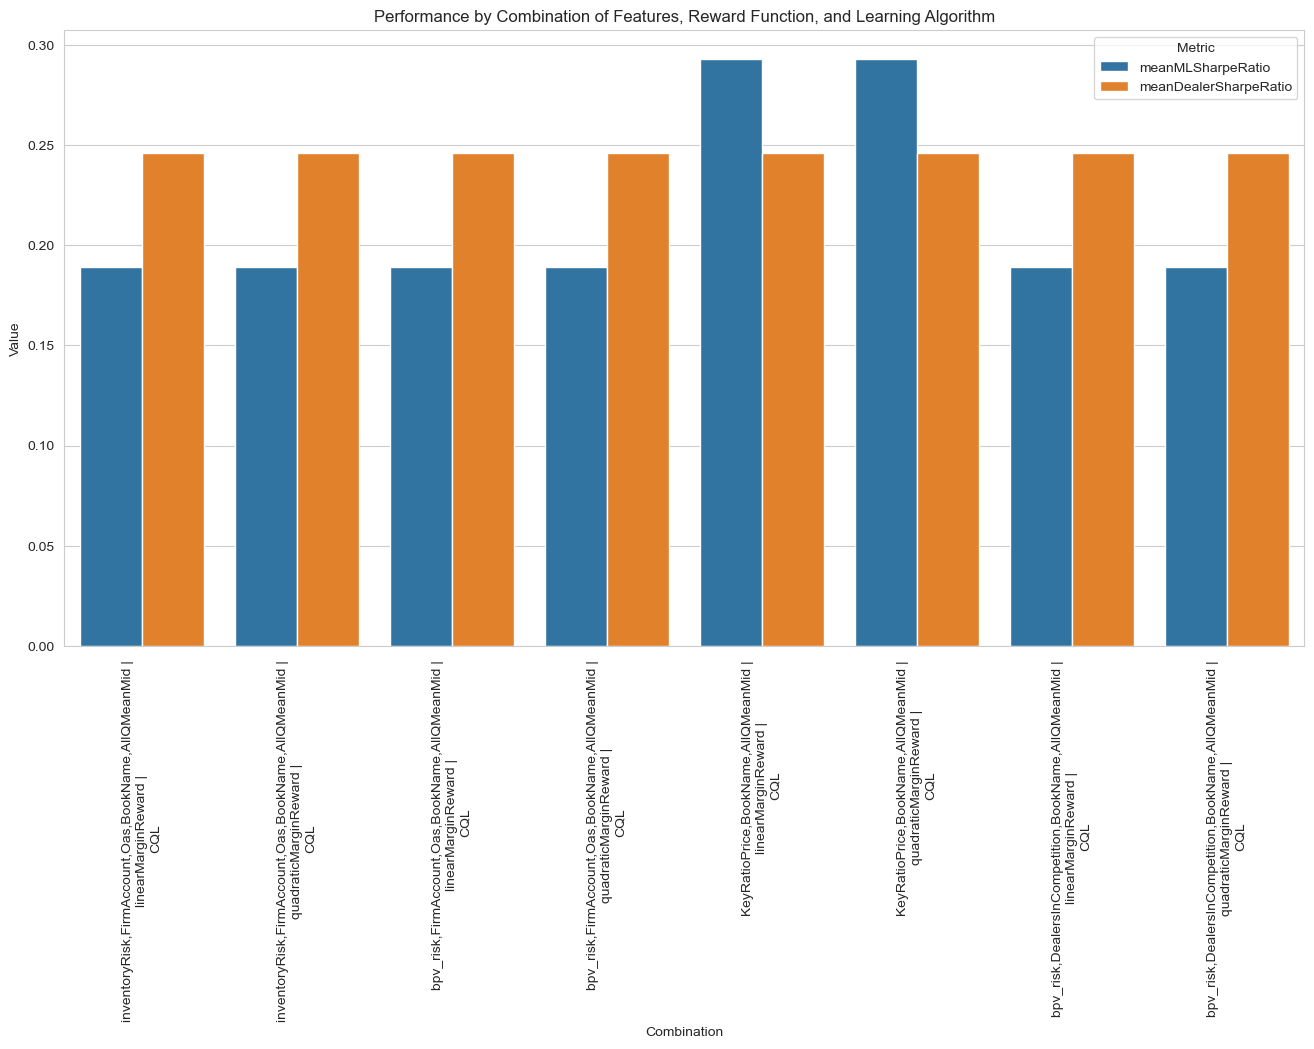

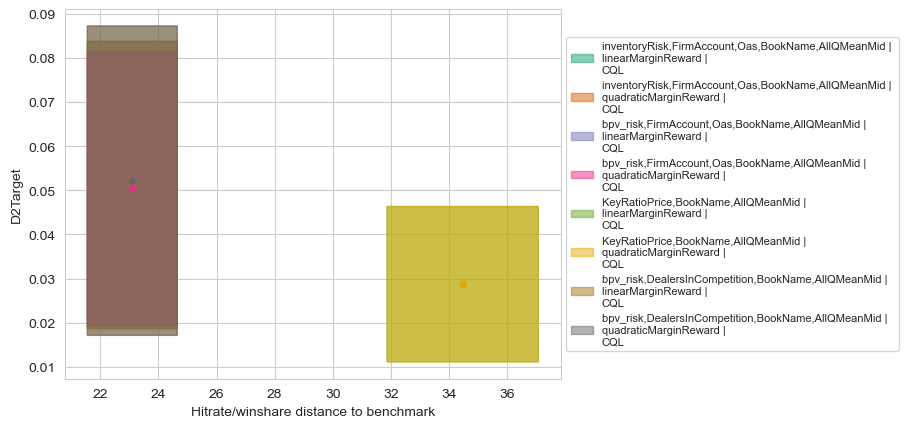



Results for ISIN DK0009515363, counts: 245
Combination: ('inventoryRisk,FirmAccount,Oas,BookName,AllQMeanMid', 'linearMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=11, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=139, out_features=155, bias=True)
)
Combination: ('inventoryRisk,FirmAccount,Oas,BookName,AllQMeanMid', 'quadraticMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=11, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=139, out_features=155, bias=True)
)
Combination: ('bpv_risk,FirmAccount,Oas,BookName,AllQMeanMid', 'linearMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=11, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=139, out_features=155, bias=True)
)


C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:69: RuntimeWarning: Mean of empty slice
  return np.nanmean(df[df["MLMarginWins"]>= 0]["MLMarginWins"]) if len(df) > 0 else 0
C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:56: RuntimeWarning: invalid value encountered in scalar divide
  return L / np.sqrt(total_squared_diffs / len(df))


Combination: ('KeyRatioPrice,BookName,AllQMeanMid', 'quadraticMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=3, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=131, out_features=155, bias=True)
)


C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:69: RuntimeWarning: Mean of empty slice
  return np.nanmean(df[df["MLMarginWins"]>= 0]["MLMarginWins"]) if len(df) > 0 else 0
C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:56: RuntimeWarning: invalid value encountered in scalar divide
  return L / np.sqrt(total_squared_diffs / len(df))


Combination: ('bpv_risk,DealersInCompetition,BookName,AllQMeanMid', 'linearMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=132, out_features=155, bias=True)
)


C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:69: RuntimeWarning: Mean of empty slice
  return np.nanmean(df[df["MLMarginWins"]>= 0]["MLMarginWins"]) if len(df) > 0 else 0
C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:56: RuntimeWarning: invalid value encountered in scalar divide
  return L / np.sqrt(total_squared_diffs / len(df))


Combination: ('bpv_risk,DealersInCompetition,BookName,AllQMeanMid', 'quadraticMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=132, out_features=155, bias=True)
)


C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:69: RuntimeWarning: Mean of empty slice
  return np.nanmean(df[df["MLMarginWins"]>= 0]["MLMarginWins"]) if len(df) > 0 else 0
C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:56: RuntimeWarning: invalid value encountered in scalar divide
  return L / np.sqrt(total_squared_diffs / len(df))


                                                                                            dealerHitRate  \
Features                                           Reward Function       Learning Algorithm                 
inventoryRisk,FirmAccount,Oas,BookName,AllQMeanMid linearMarginReward    CQL                    27.272727   
                                                   quadraticMarginReward CQL                    27.272727   
bpv_risk,FirmAccount,Oas,BookName,AllQMeanMid      linearMarginReward    CQL                    27.272727   
                                                   quadraticMarginReward CQL                    27.272727   
KeyRatioPrice,BookName,AllQMeanMid                 linearMarginReward    CQL                    27.272727   
                                                   quadraticMarginReward CQL                    27.272727   
bpv_risk,DealersInCompetition,BookName,AllQMeanMid linearMarginReward    CQL                    27.272727   
                   

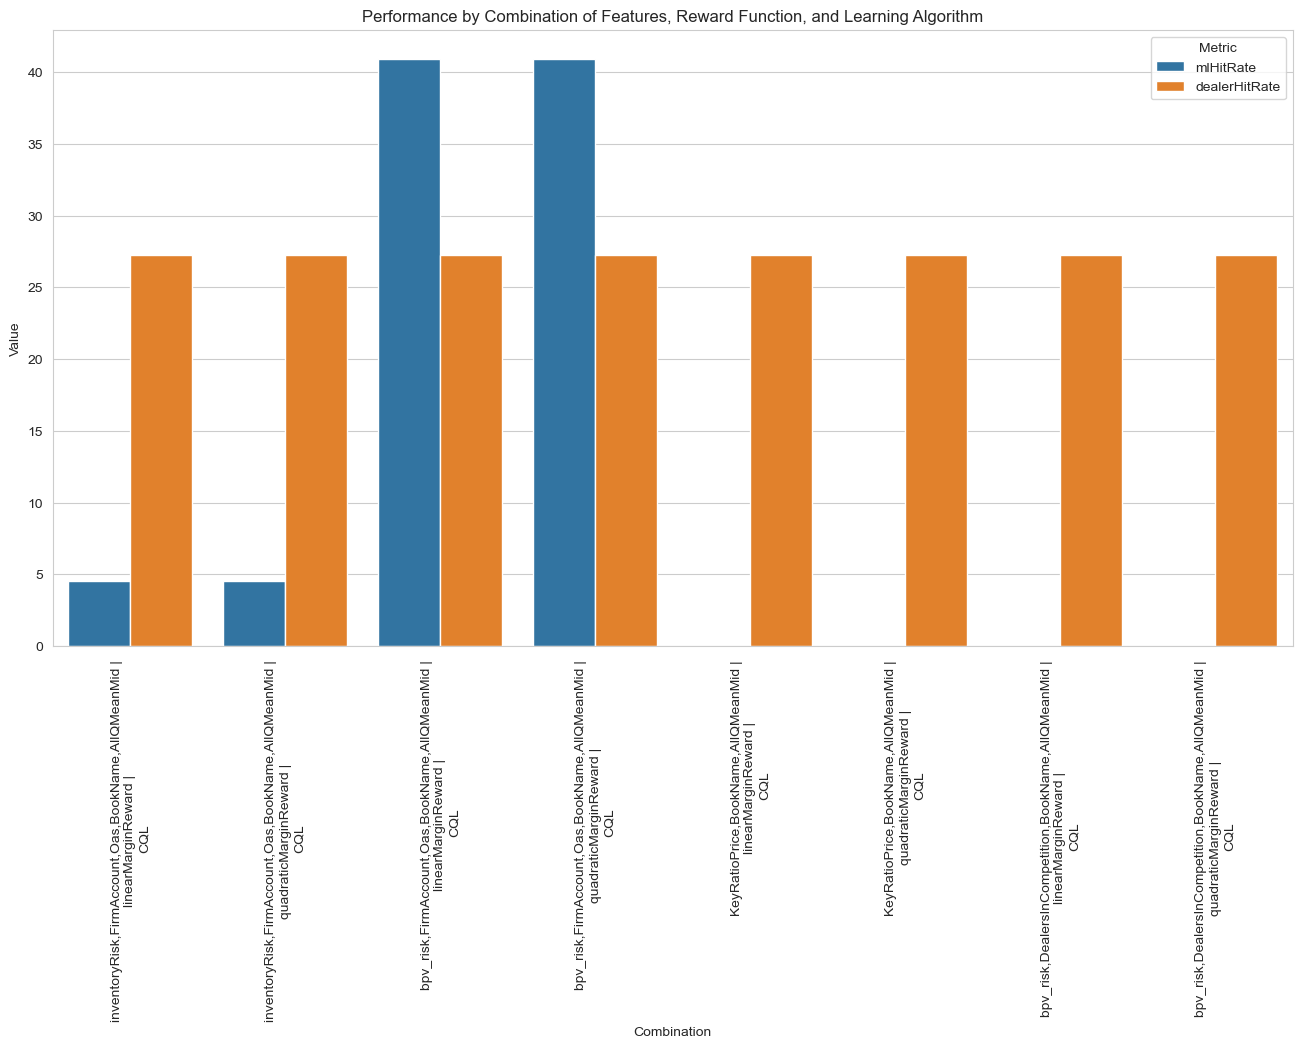

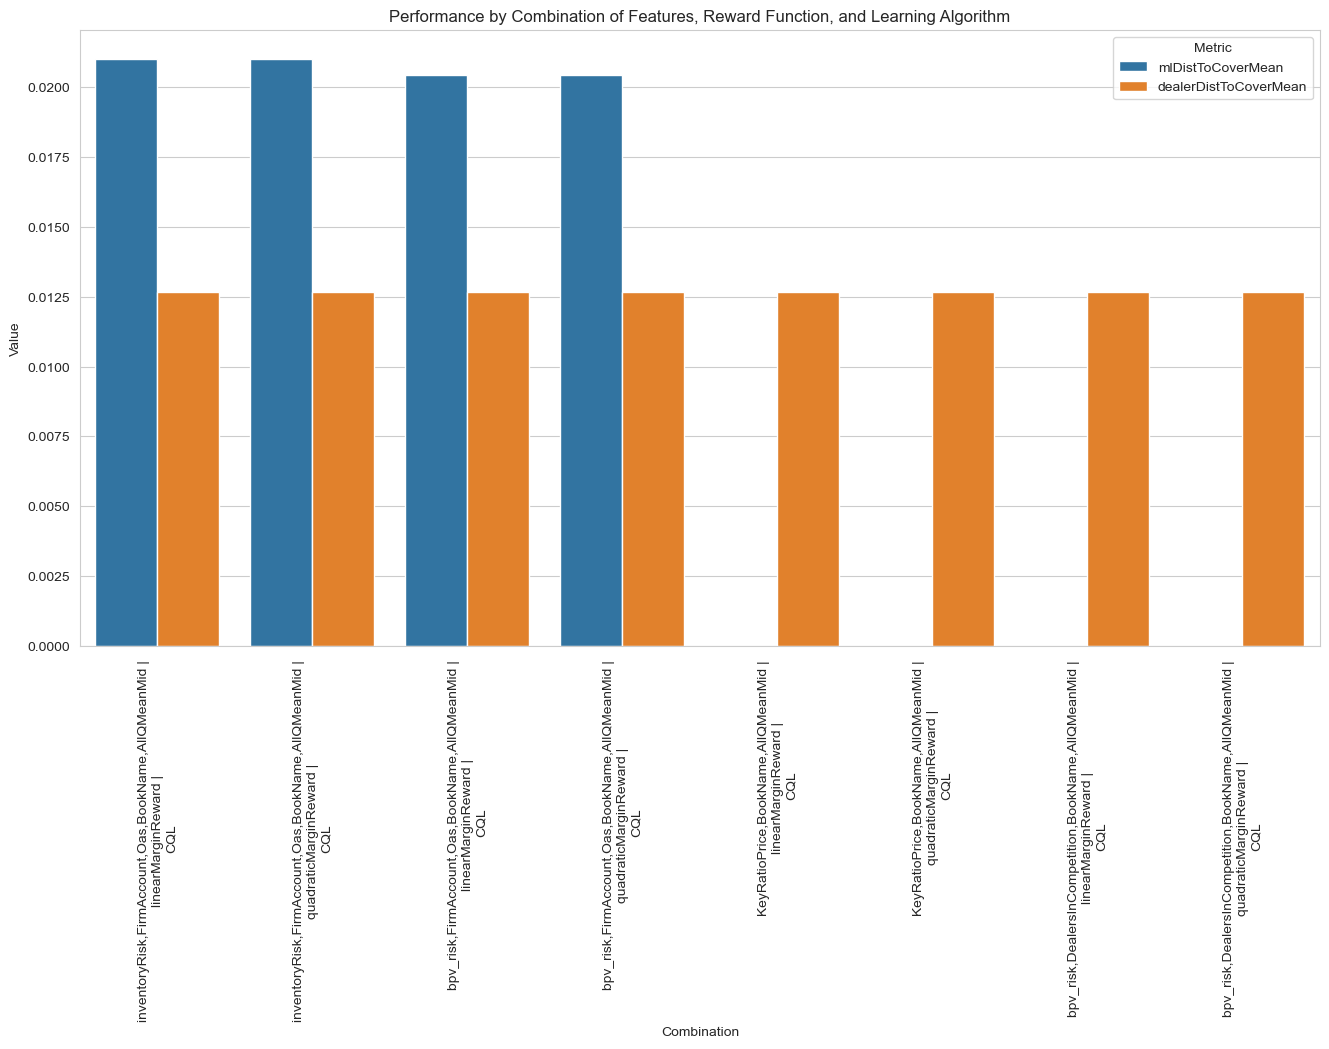

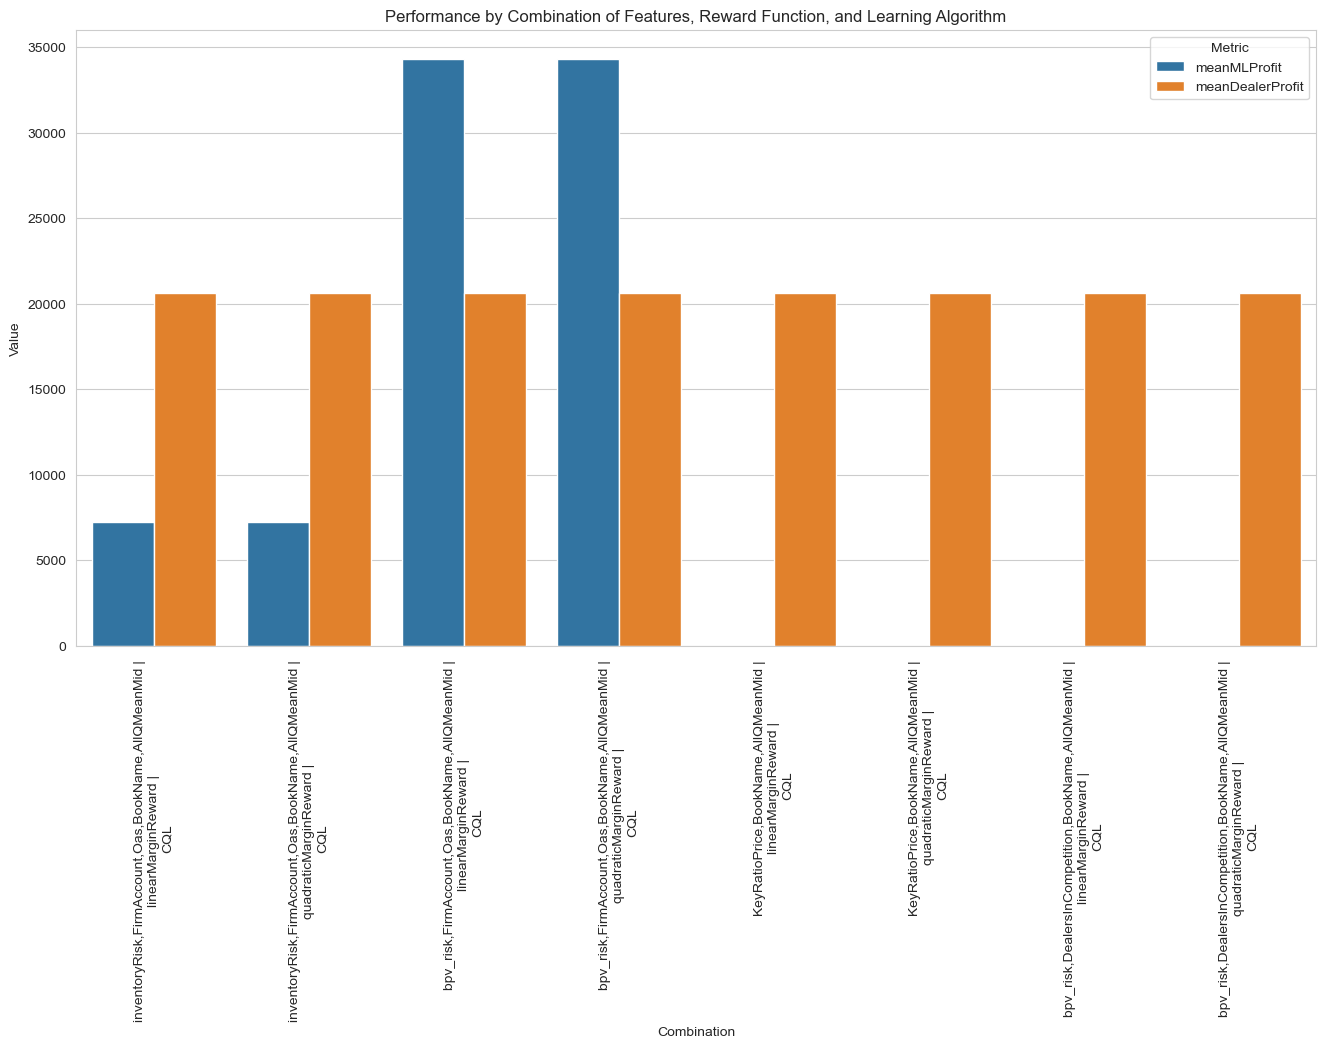

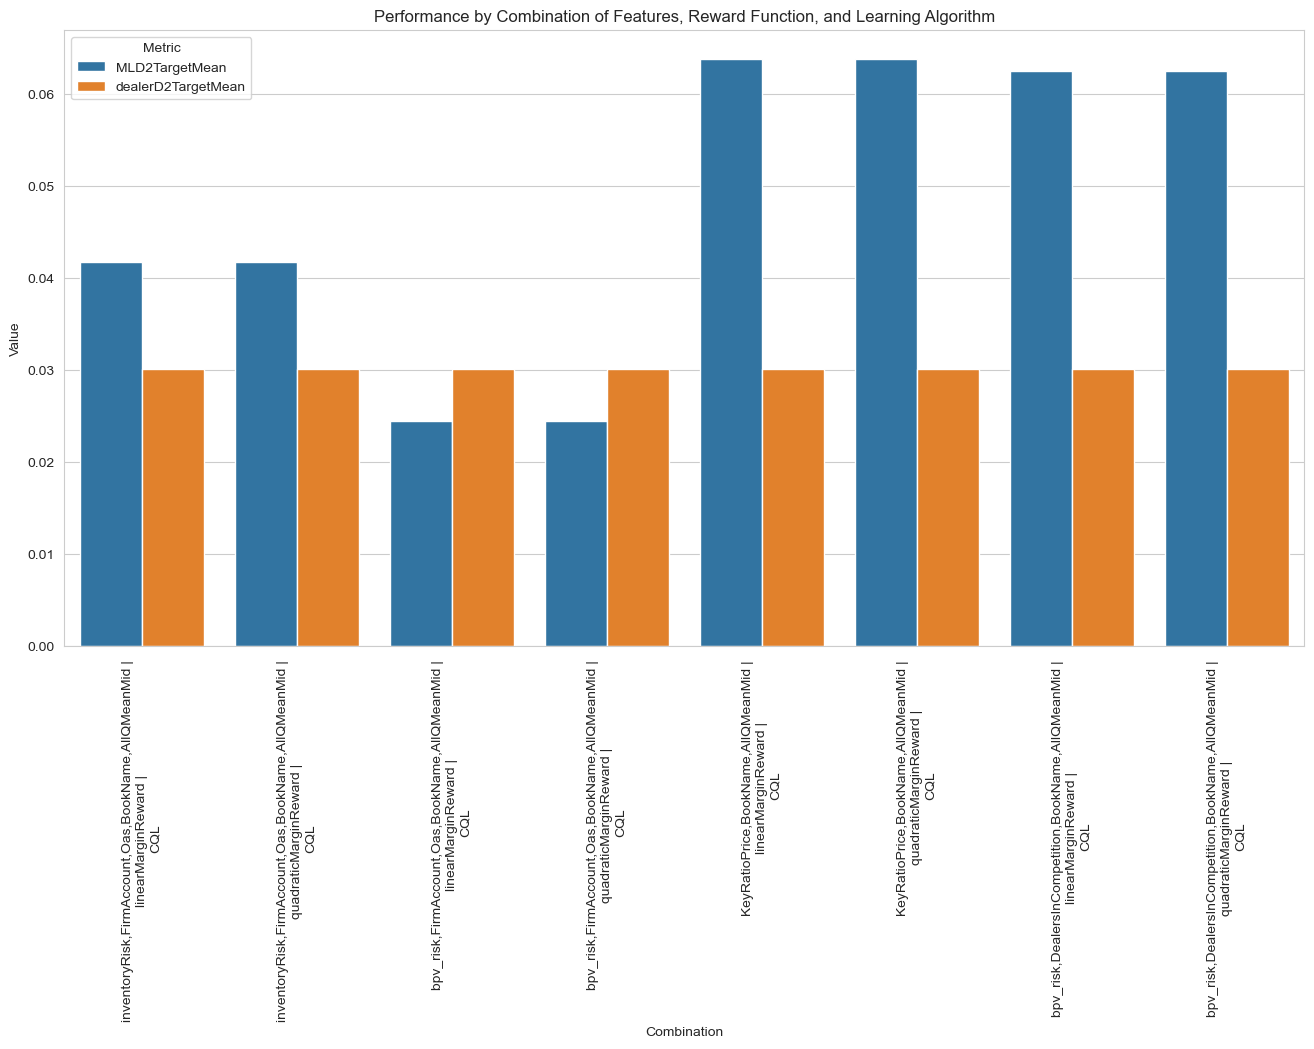

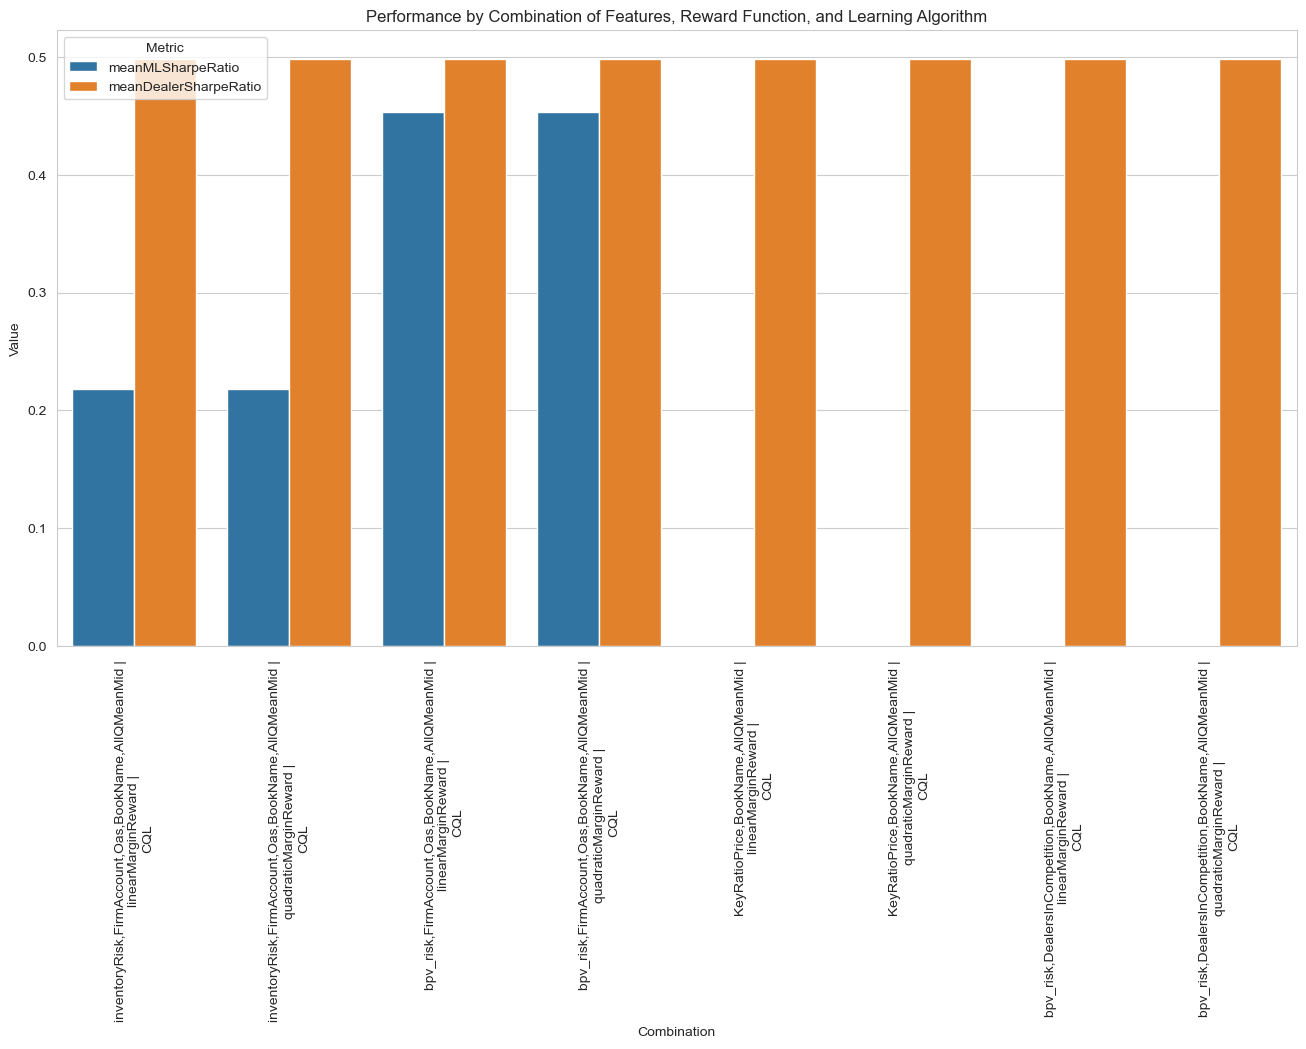

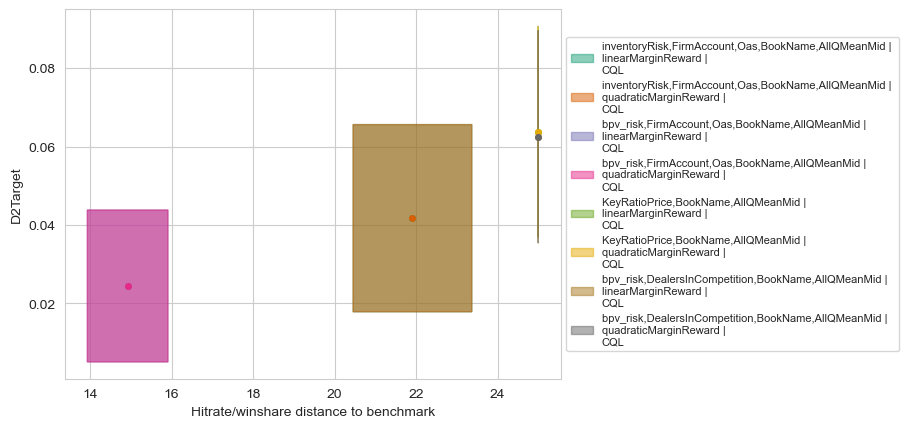



Results for ISIN DK0009296469, counts: 226
Combination: ('inventoryRisk,FirmAccount,Oas,BookName,AllQMeanMid', 'linearMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=17, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=145, out_features=155, bias=True)
)


C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:69: RuntimeWarning: Mean of empty slice
  return np.nanmean(df[df["MLMarginWins"]>= 0]["MLMarginWins"]) if len(df) > 0 else 0
C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:56: RuntimeWarning: invalid value encountered in scalar divide
  return L / np.sqrt(total_squared_diffs / len(df))


Combination: ('inventoryRisk,FirmAccount,Oas,BookName,AllQMeanMid', 'quadraticMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=17, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=145, out_features=155, bias=True)
)


C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:69: RuntimeWarning: Mean of empty slice
  return np.nanmean(df[df["MLMarginWins"]>= 0]["MLMarginWins"]) if len(df) > 0 else 0
C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:56: RuntimeWarning: invalid value encountered in scalar divide
  return L / np.sqrt(total_squared_diffs / len(df))


Combination: ('bpv_risk,FirmAccount,Oas,BookName,AllQMeanMid', 'linearMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=17, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=145, out_features=155, bias=True)
)


C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:69: RuntimeWarning: Mean of empty slice
  return np.nanmean(df[df["MLMarginWins"]>= 0]["MLMarginWins"]) if len(df) > 0 else 0
C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:56: RuntimeWarning: invalid value encountered in scalar divide
  return L / np.sqrt(total_squared_diffs / len(df))


Combination: ('bpv_risk,FirmAccount,Oas,BookName,AllQMeanMid', 'quadraticMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=17, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=145, out_features=155, bias=True)
)


C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:69: RuntimeWarning: Mean of empty slice
  return np.nanmean(df[df["MLMarginWins"]>= 0]["MLMarginWins"]) if len(df) > 0 else 0
C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:56: RuntimeWarning: invalid value encountered in scalar divide
  return L / np.sqrt(total_squared_diffs / len(df))


Combination: ('KeyRatioPrice,BookName,AllQMeanMid', 'linearMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=132, out_features=155, bias=True)
)
Combination: ('KeyRatioPrice,BookName,AllQMeanMid', 'quadraticMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=132, out_features=155, bias=True)
)
Combination: ('bpv_risk,DealersInCompetition,BookName,AllQMeanMid', 'linearMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=133, out_features=155, bias=True)
)


C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:69: RuntimeWarning: Mean of empty slice
  return np.nanmean(df[df["MLMarginWins"]>= 0]["MLMarginWins"]) if len(df) > 0 else 0
C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:56: RuntimeWarning: invalid value encountered in scalar divide
  return L / np.sqrt(total_squared_diffs / len(df))


Combination: ('bpv_risk,DealersInCompetition,BookName,AllQMeanMid', 'quadraticMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=133, out_features=155, bias=True)
)


C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:69: RuntimeWarning: Mean of empty slice
  return np.nanmean(df[df["MLMarginWins"]>= 0]["MLMarginWins"]) if len(df) > 0 else 0
C:\Udvikler/Speciale/SpecialeKode\model_evaluation\eval_utilities.py:56: RuntimeWarning: invalid value encountered in scalar divide
  return L / np.sqrt(total_squared_diffs / len(df))


                                                                                            dealerHitRate  \
Features                                           Reward Function       Learning Algorithm                 
inventoryRisk,FirmAccount,Oas,BookName,AllQMeanMid linearMarginReward    CQL                     3.703704   
                                                   quadraticMarginReward CQL                     3.703704   
bpv_risk,FirmAccount,Oas,BookName,AllQMeanMid      linearMarginReward    CQL                     3.703704   
                                                   quadraticMarginReward CQL                     3.703704   
KeyRatioPrice,BookName,AllQMeanMid                 linearMarginReward    CQL                     3.703704   
                                                   quadraticMarginReward CQL                     3.703704   
bpv_risk,DealersInCompetition,BookName,AllQMeanMid linearMarginReward    CQL                     3.703704   
                   

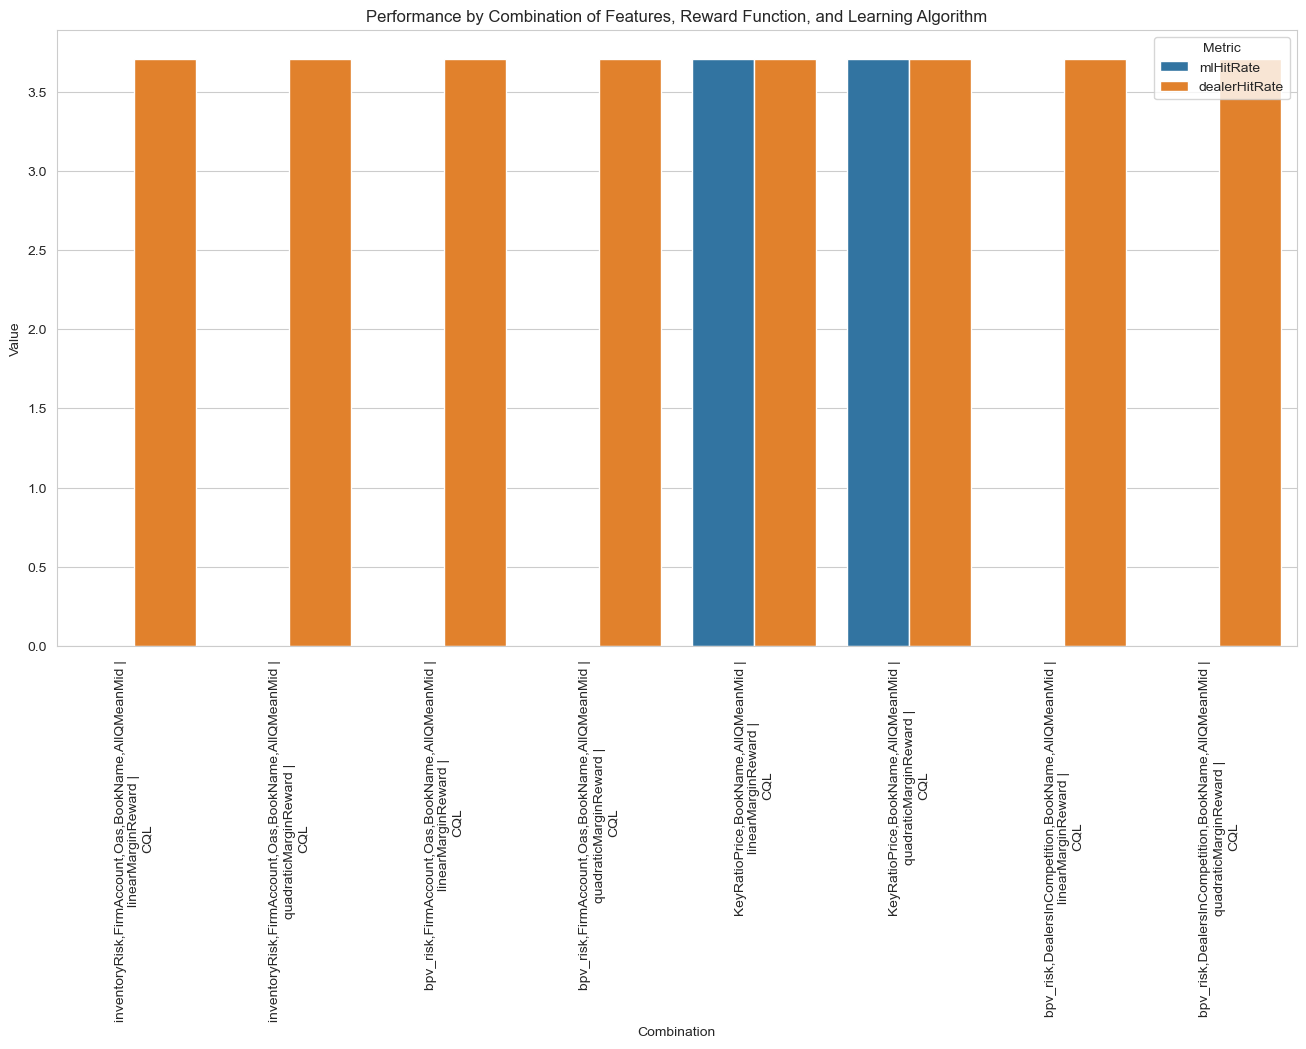

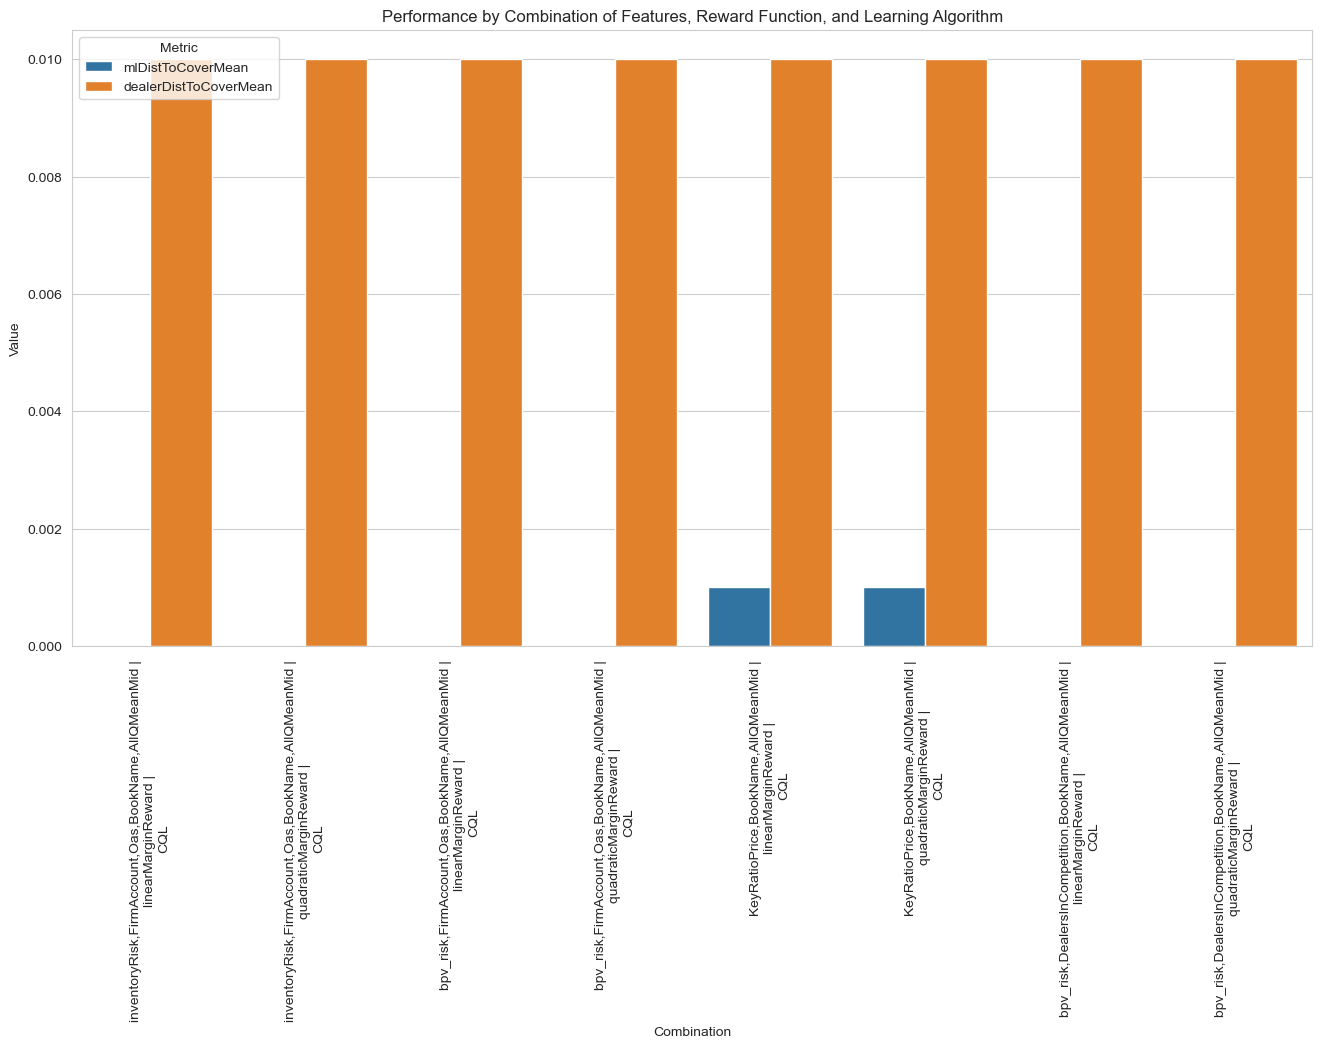

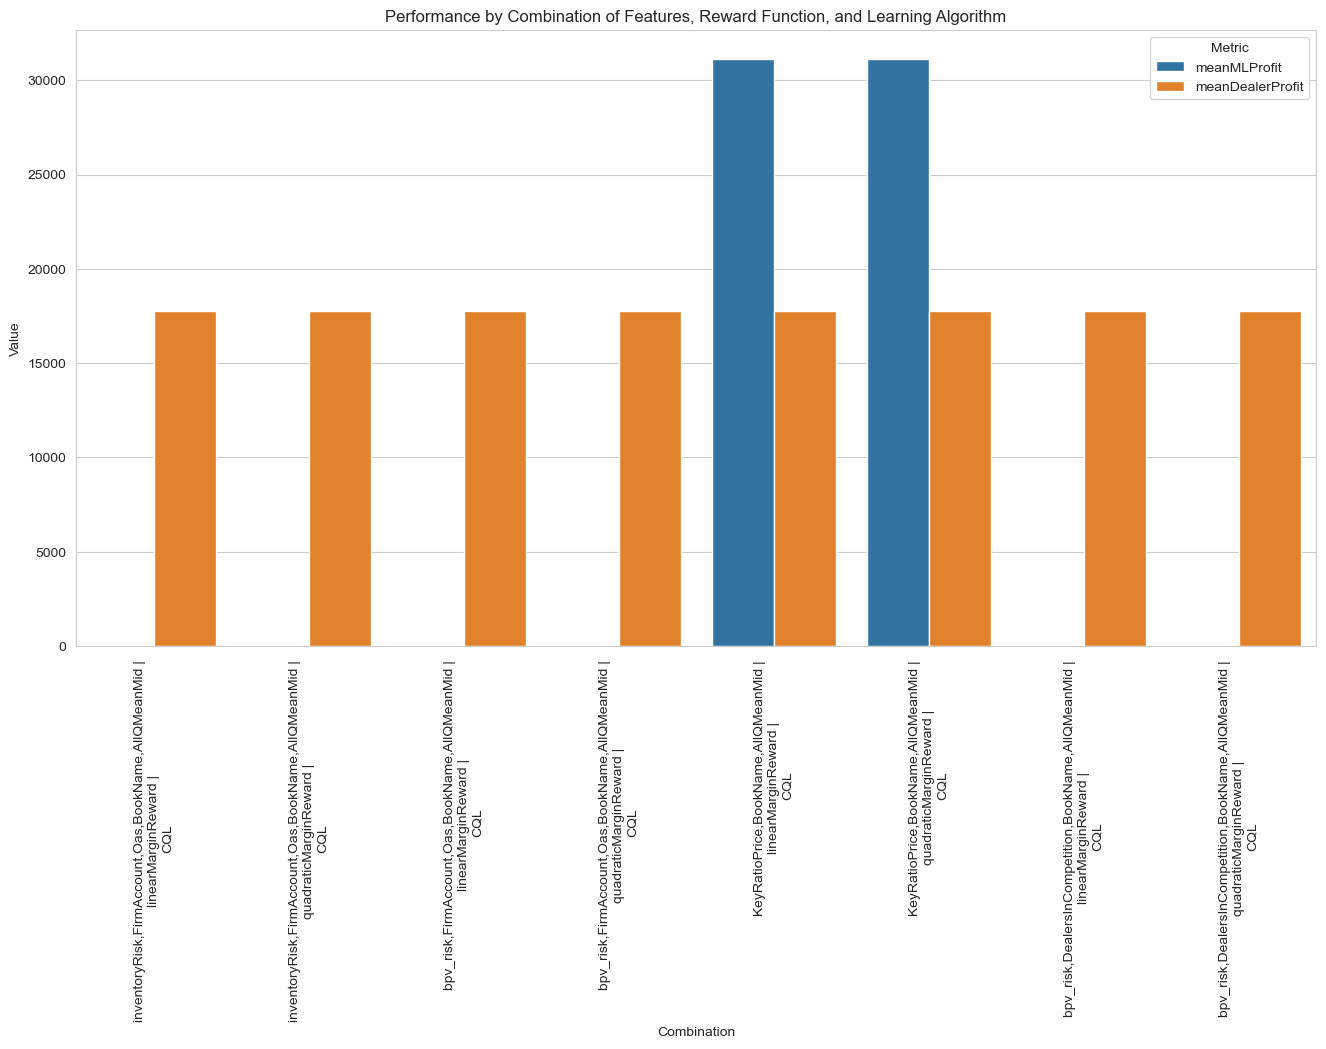

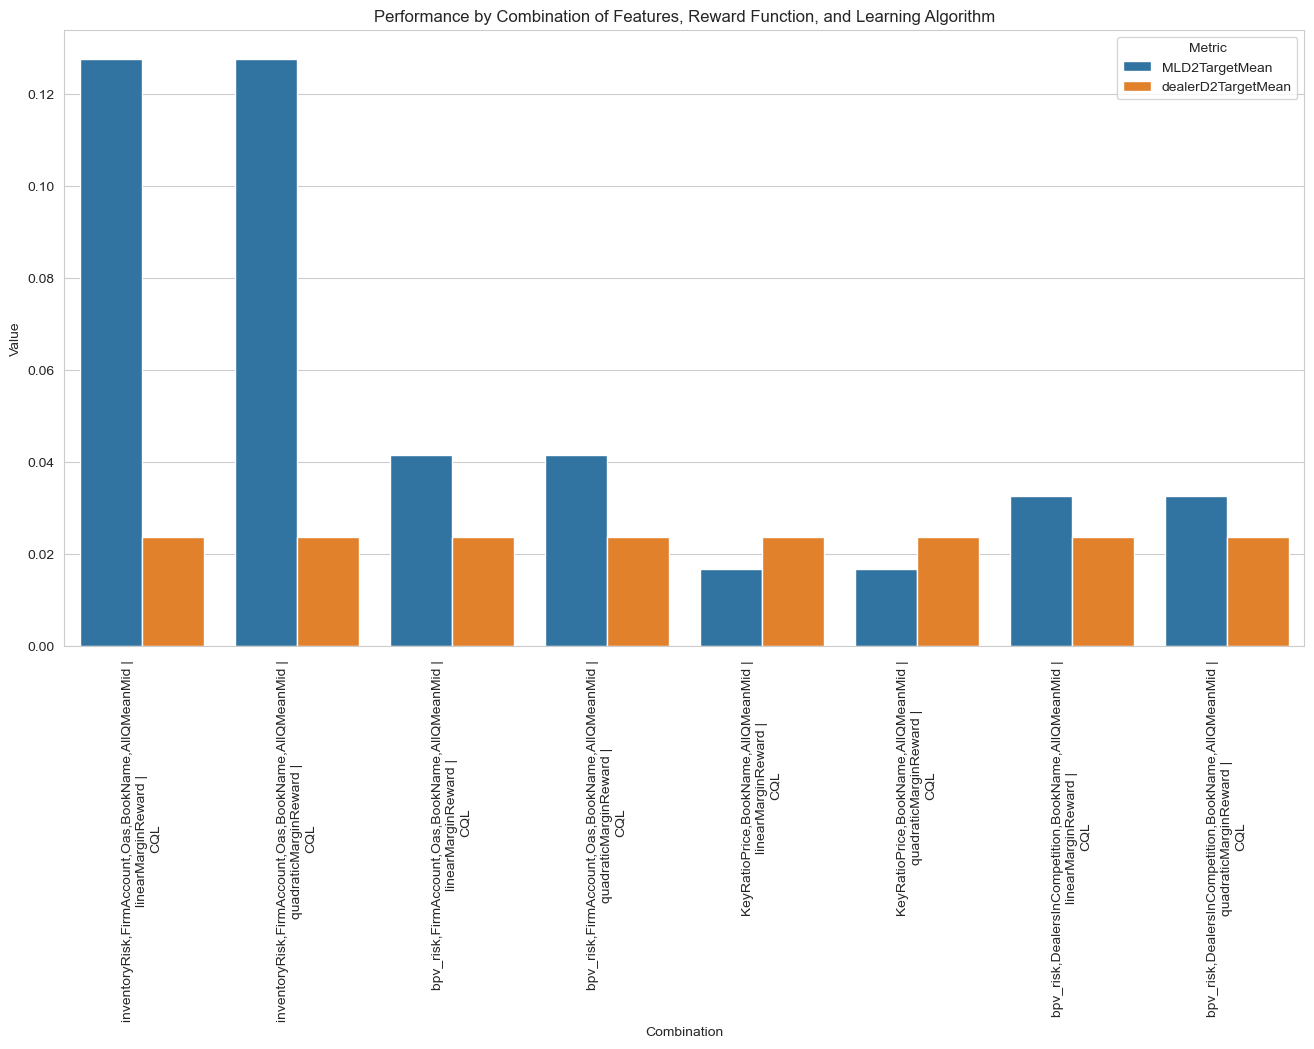

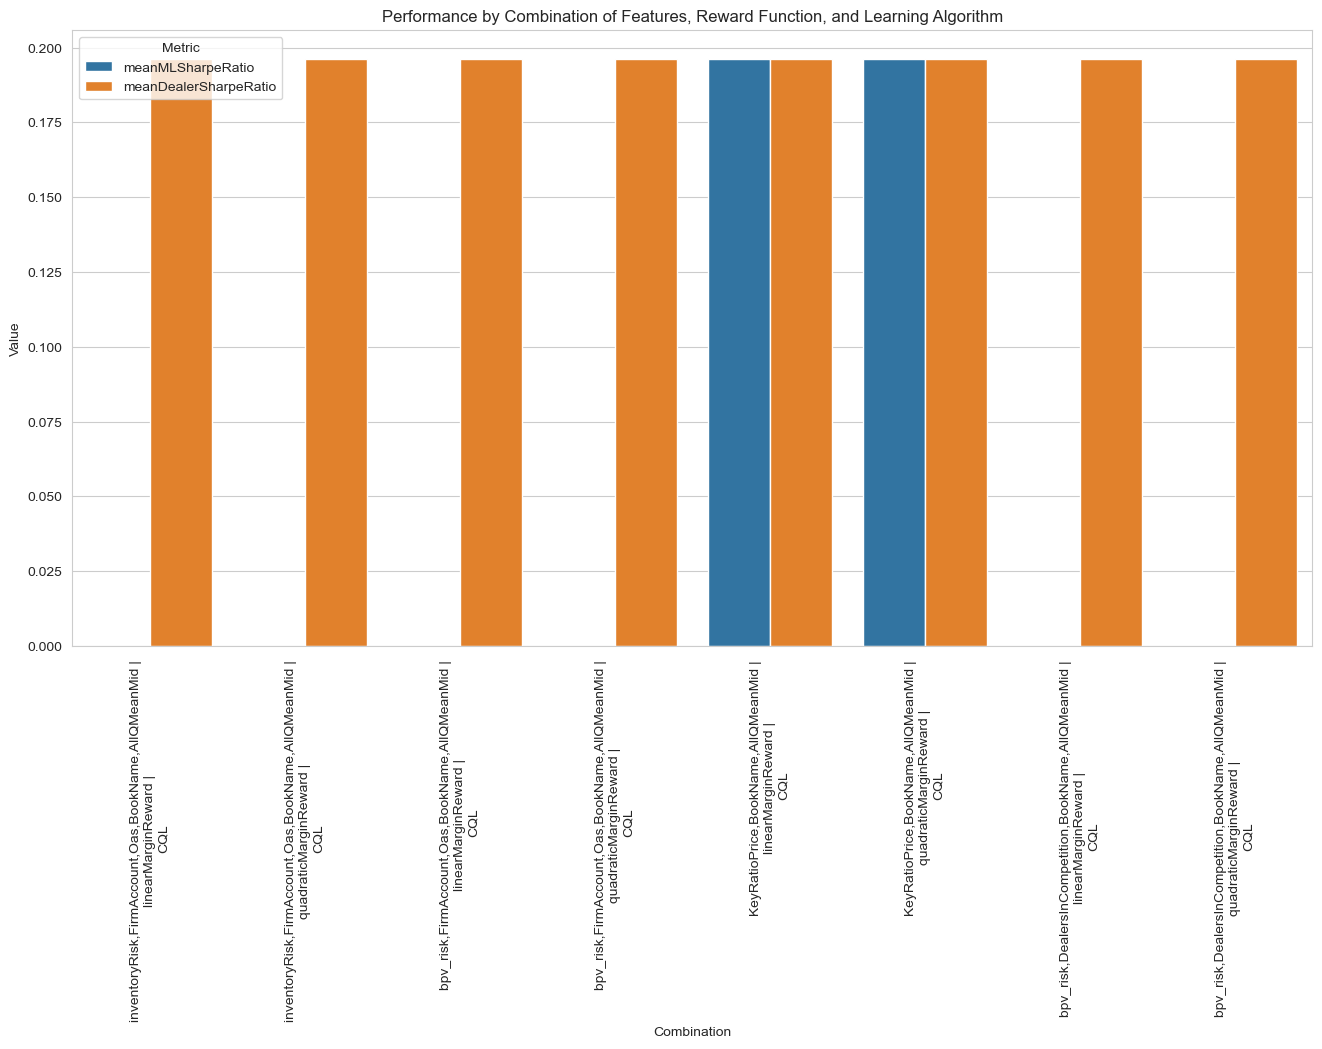

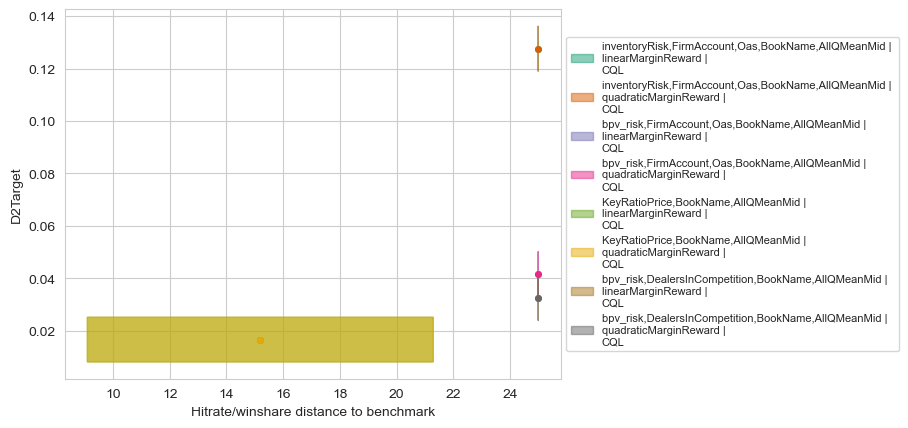



Results for ISIN DK0009295149, counts: 216
Combination: ('inventoryRisk,FirmAccount,Oas,BookName,AllQMeanMid', 'linearMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=13, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=141, out_features=155, bias=True)
)
Combination: ('inventoryRisk,FirmAccount,Oas,BookName,AllQMeanMid', 'quadraticMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=13, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=141, out_features=155, bias=True)
)
Combination: ('bpv_risk,FirmAccount,Oas,BookName,AllQMeanMid', 'linearMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=13, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=141, out_features=155, bias=True)
)


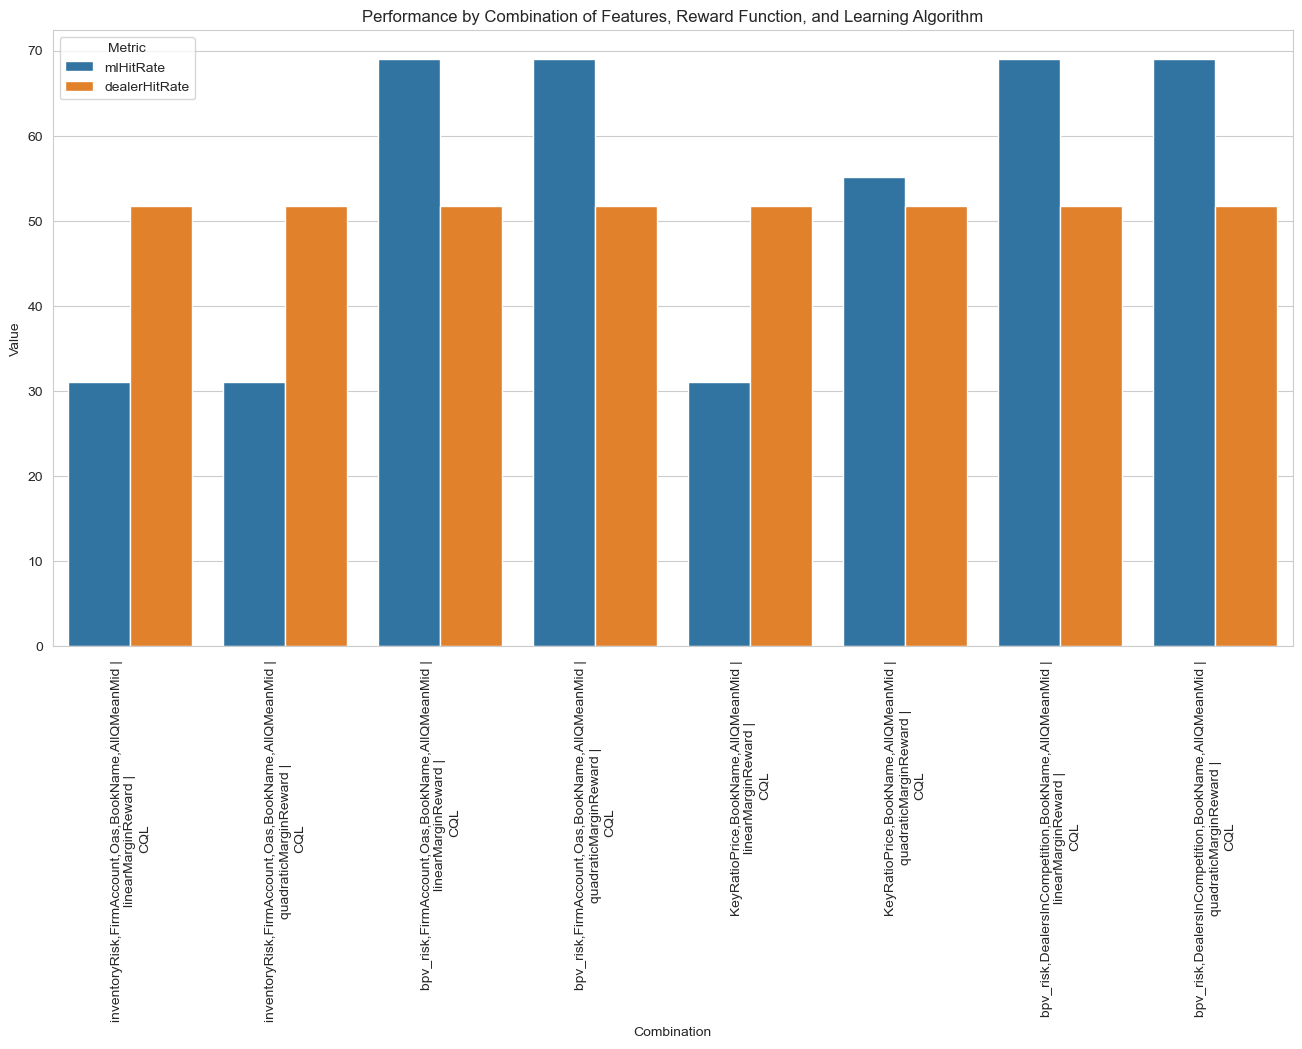

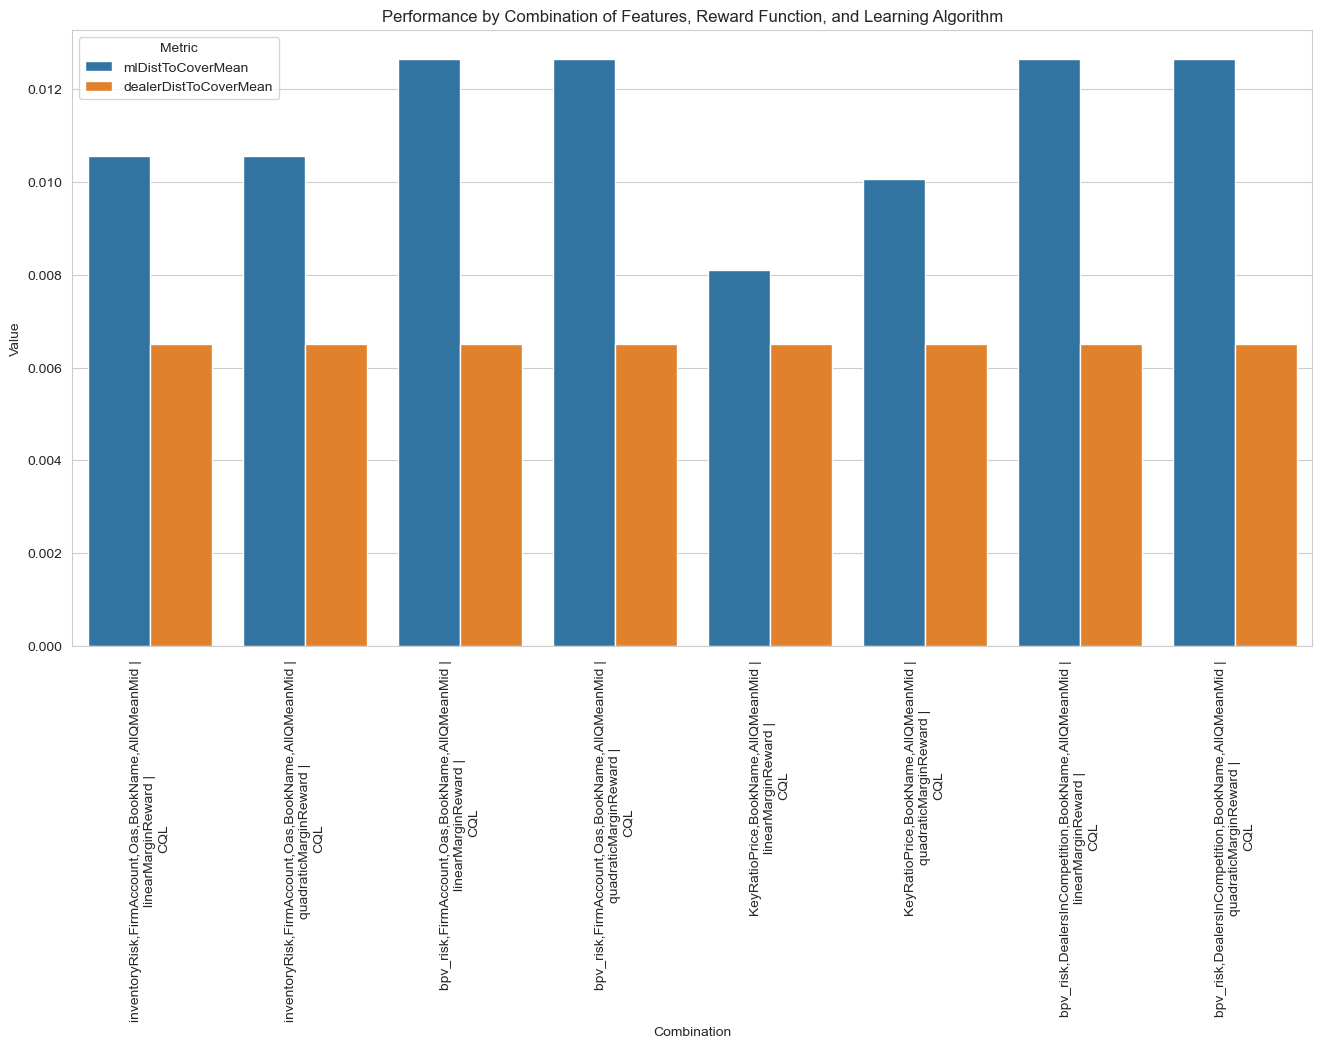

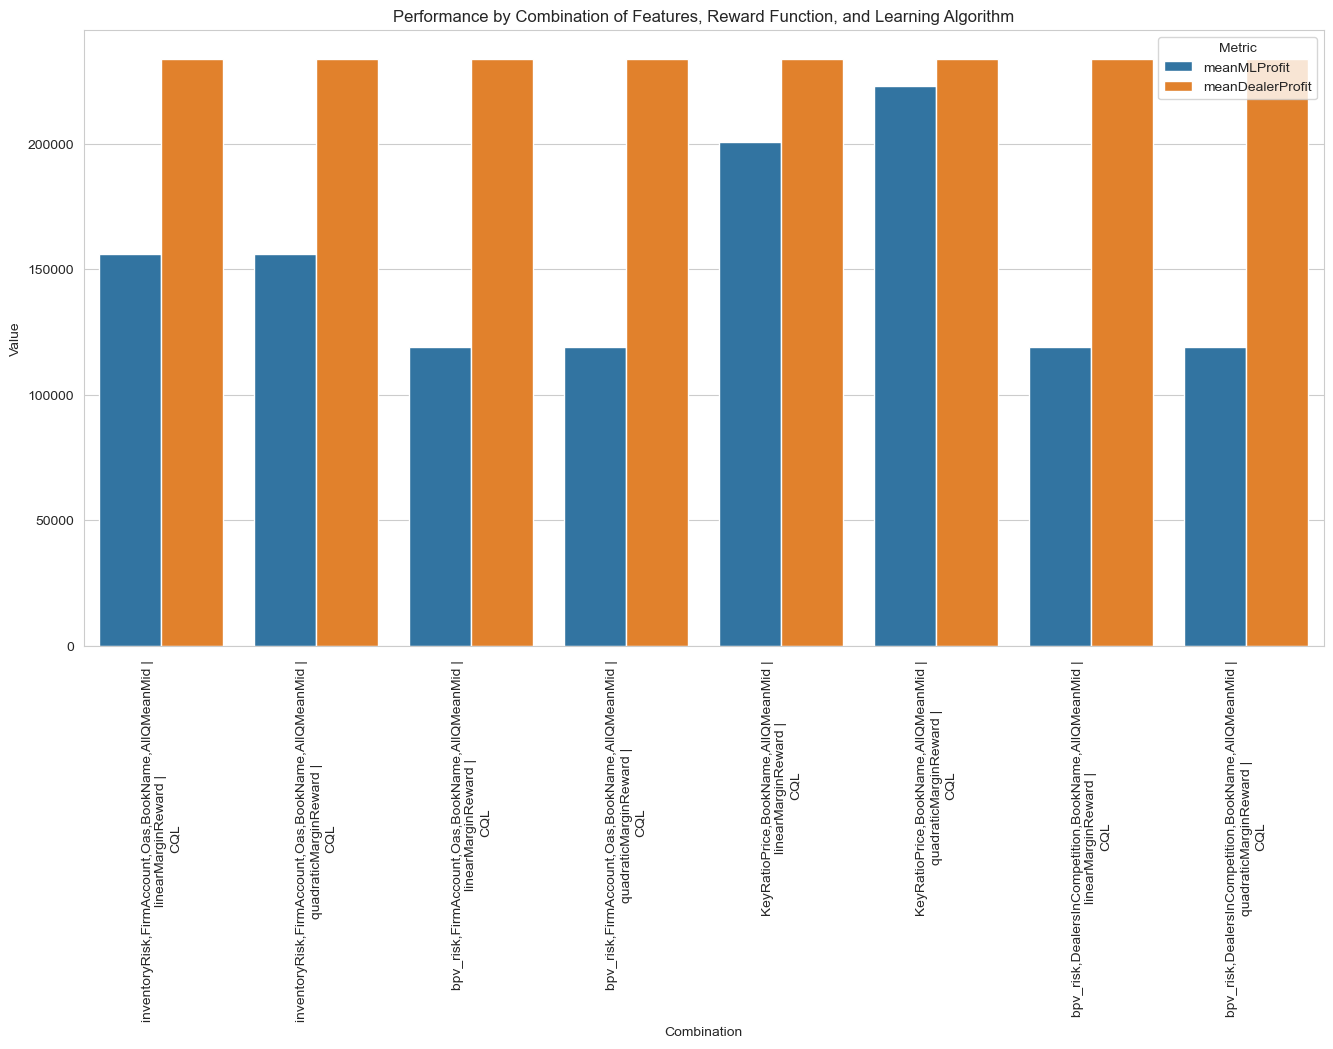

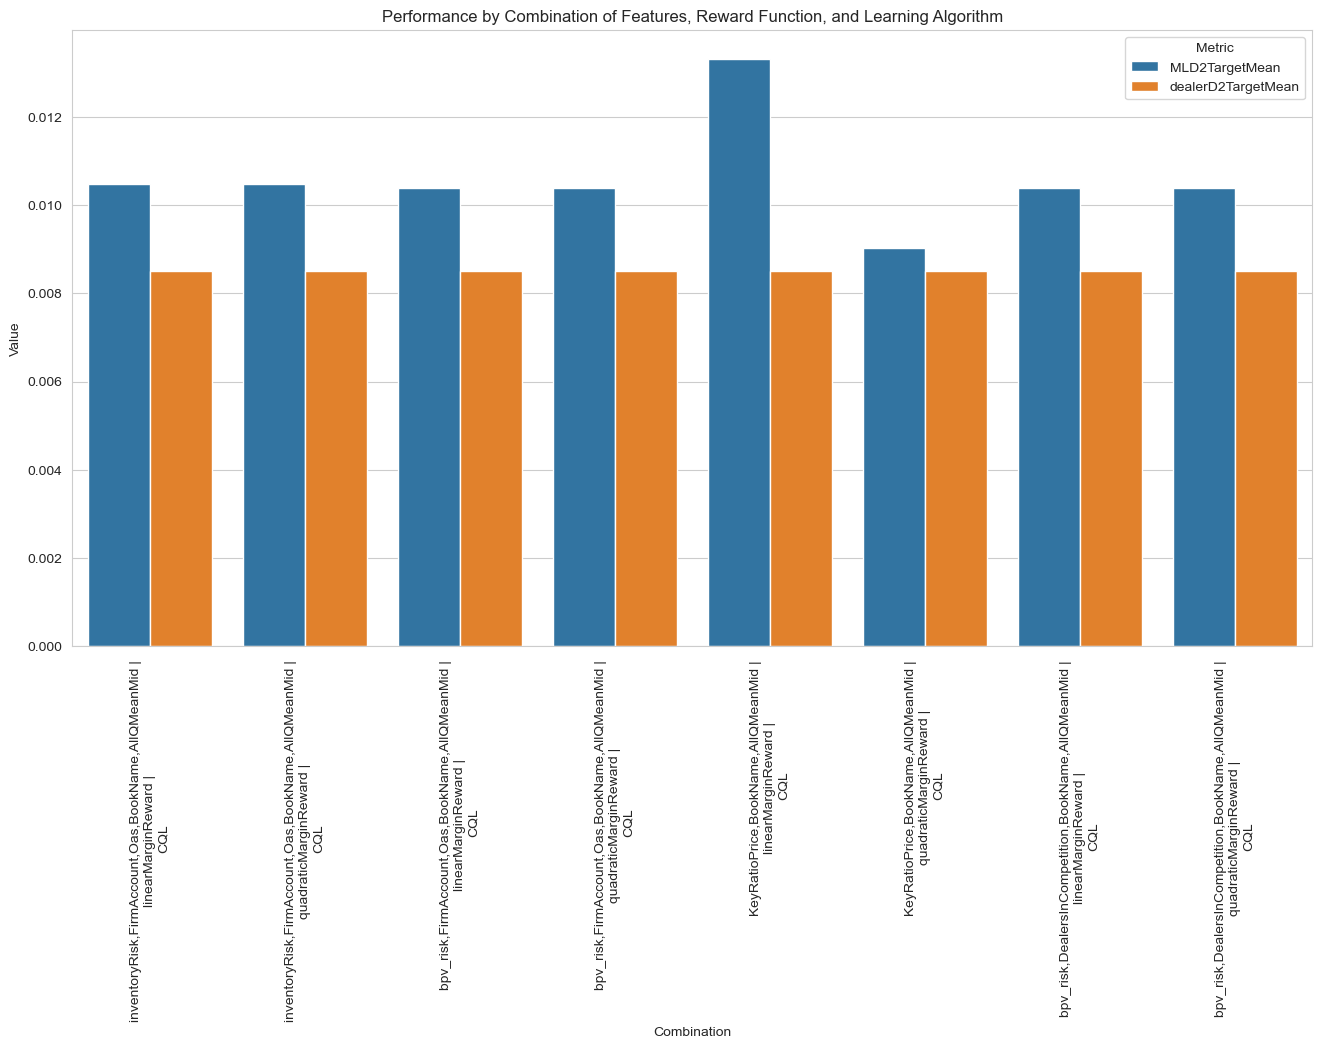

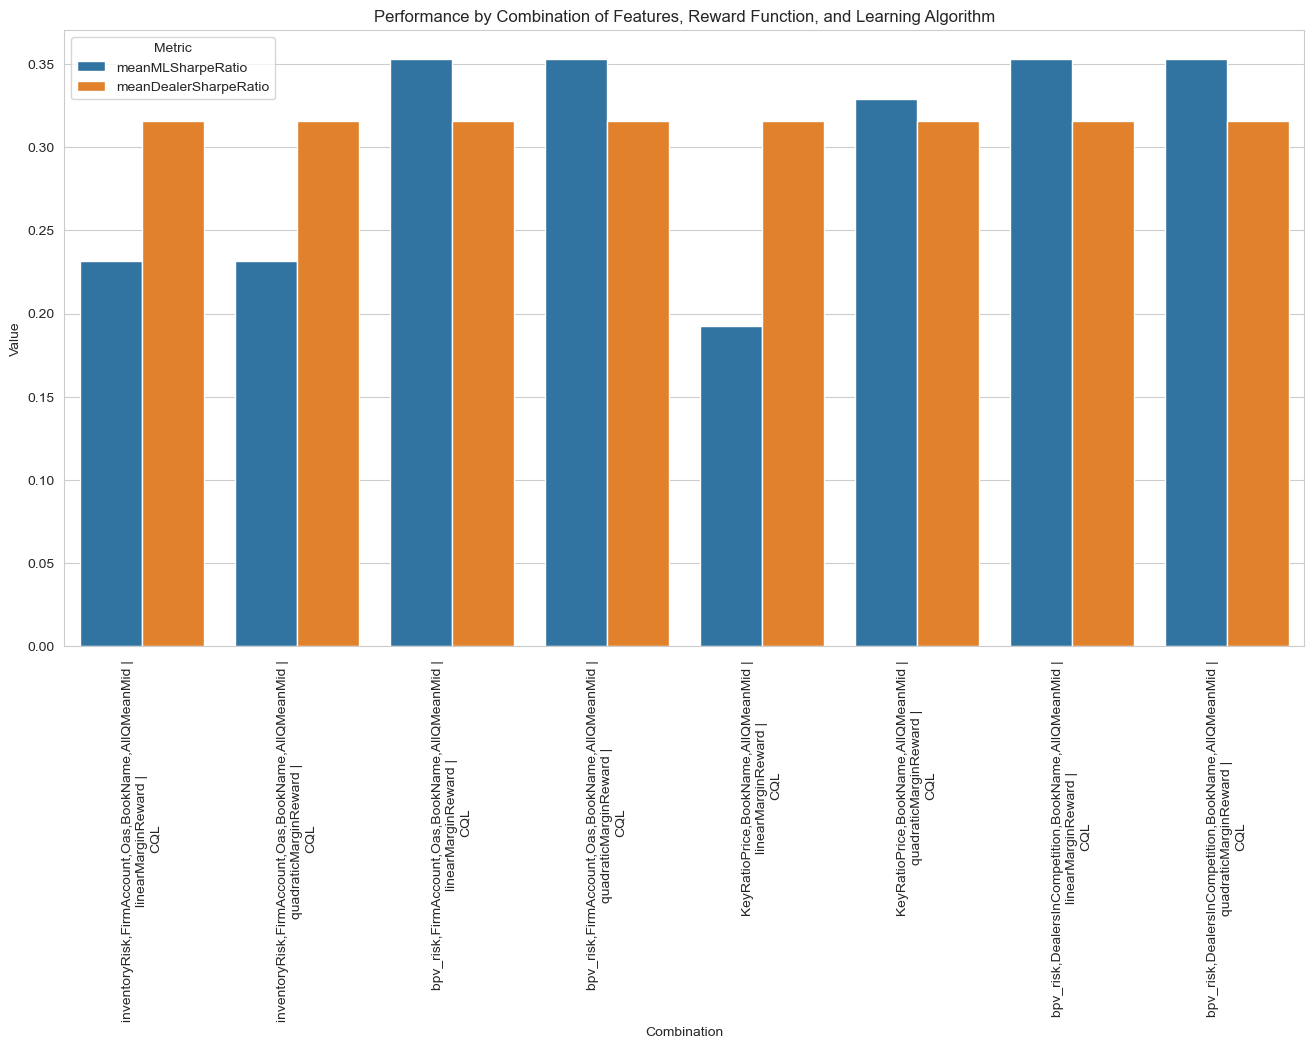

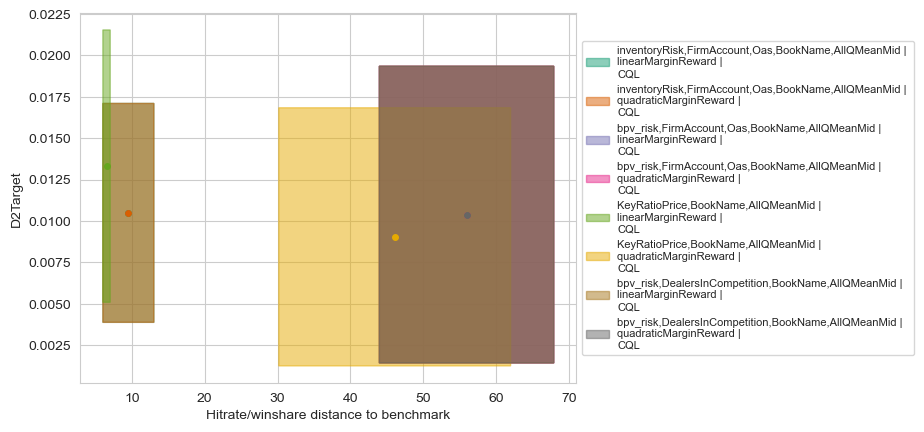



Results for ISIN DK0009295222, counts: 198
Combination: ('inventoryRisk,FirmAccount,Oas,BookName,AllQMeanMid', 'linearMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=15, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=143, out_features=155, bias=True)
)
Combination: ('inventoryRisk,FirmAccount,Oas,BookName,AllQMeanMid', 'quadraticMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=15, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=143, out_features=155, bias=True)
)
Combination: ('bpv_risk,FirmAccount,Oas,BookName,AllQMeanMid', 'linearMarginReward', 'CQL') 

QNetworkSkipConnection(
  (fc1): Linear(in_features=15, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=143, out_features=155, bias=True)
)


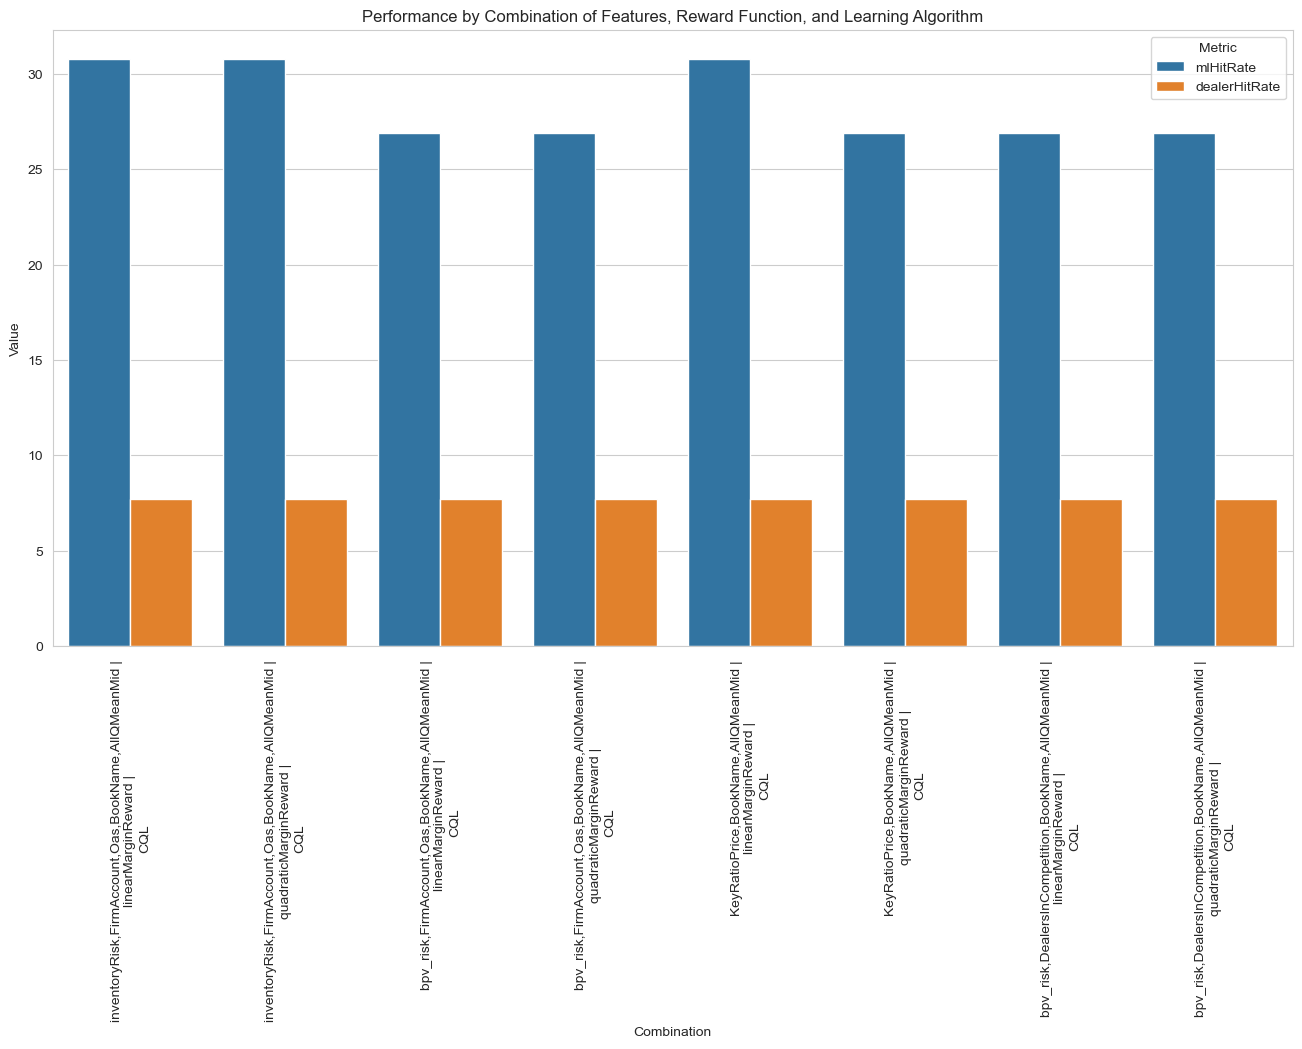

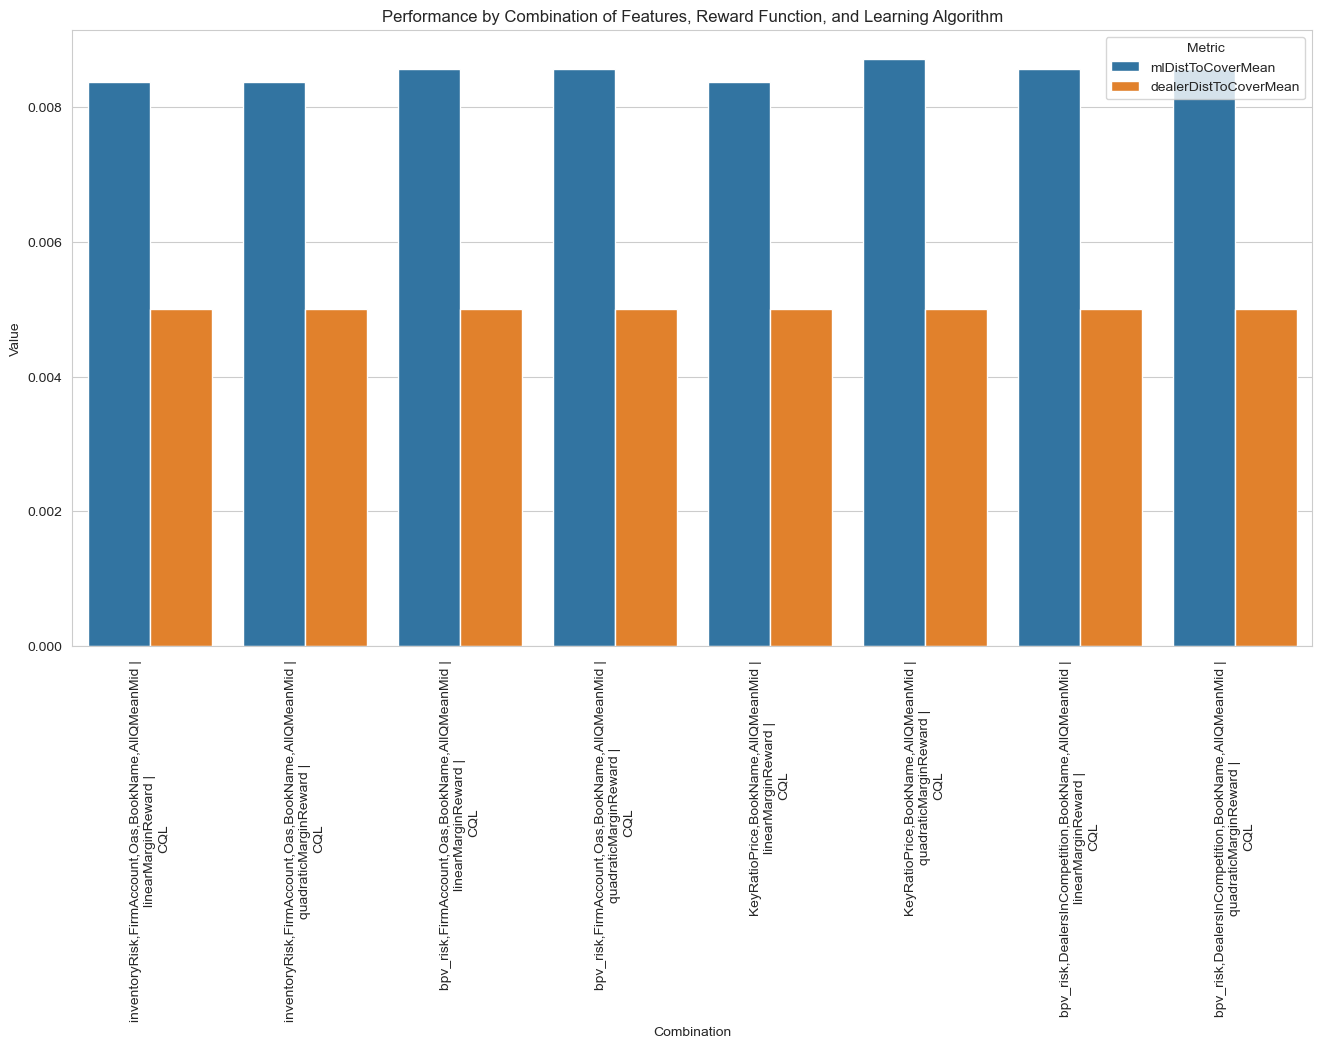

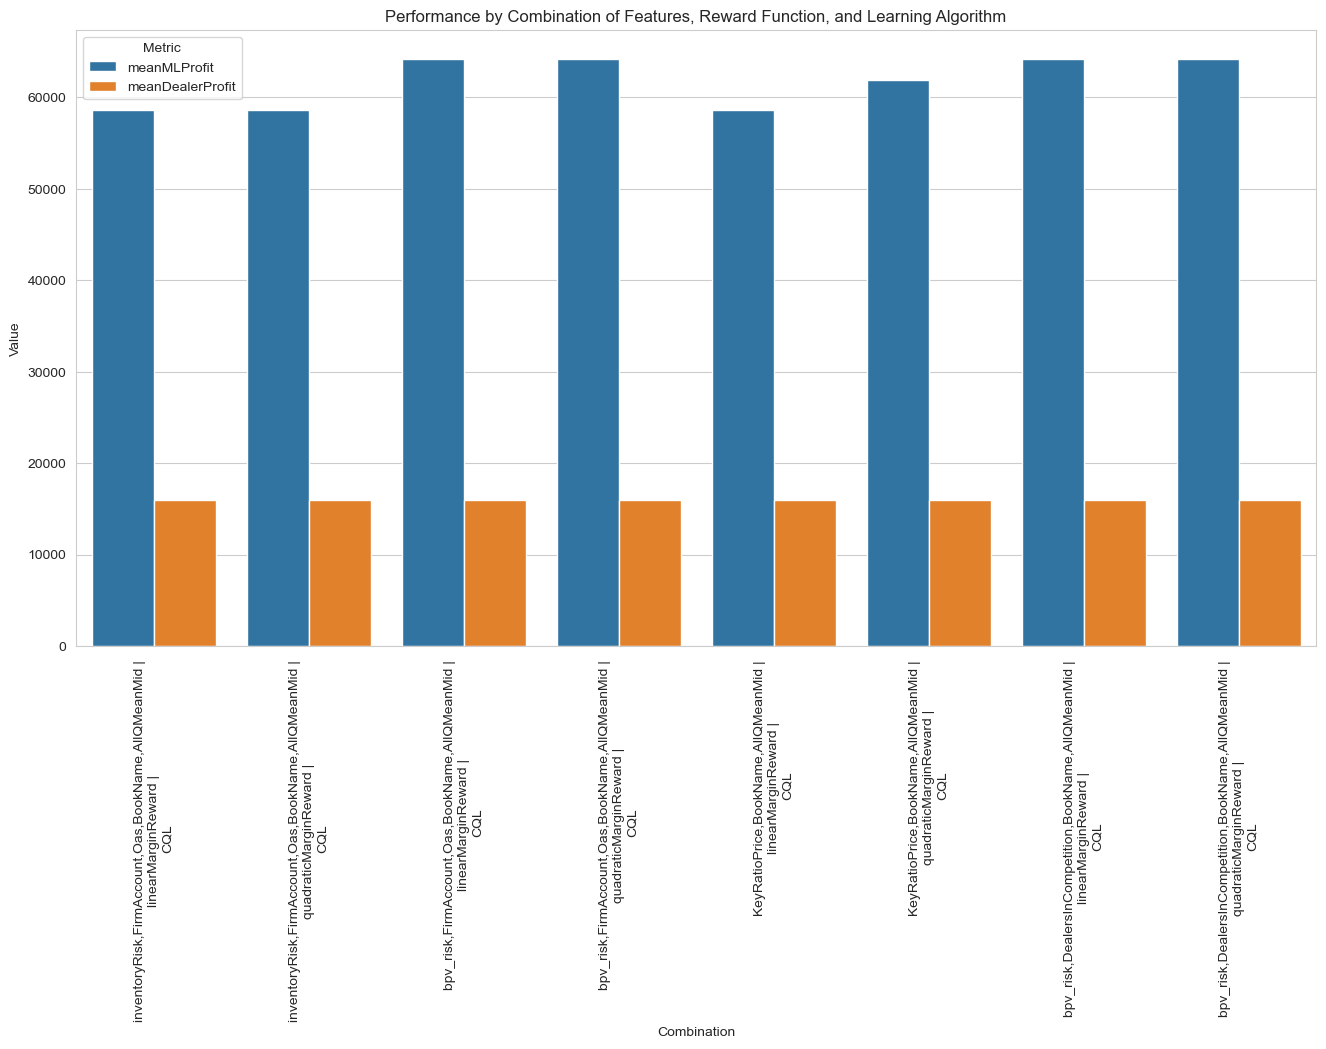

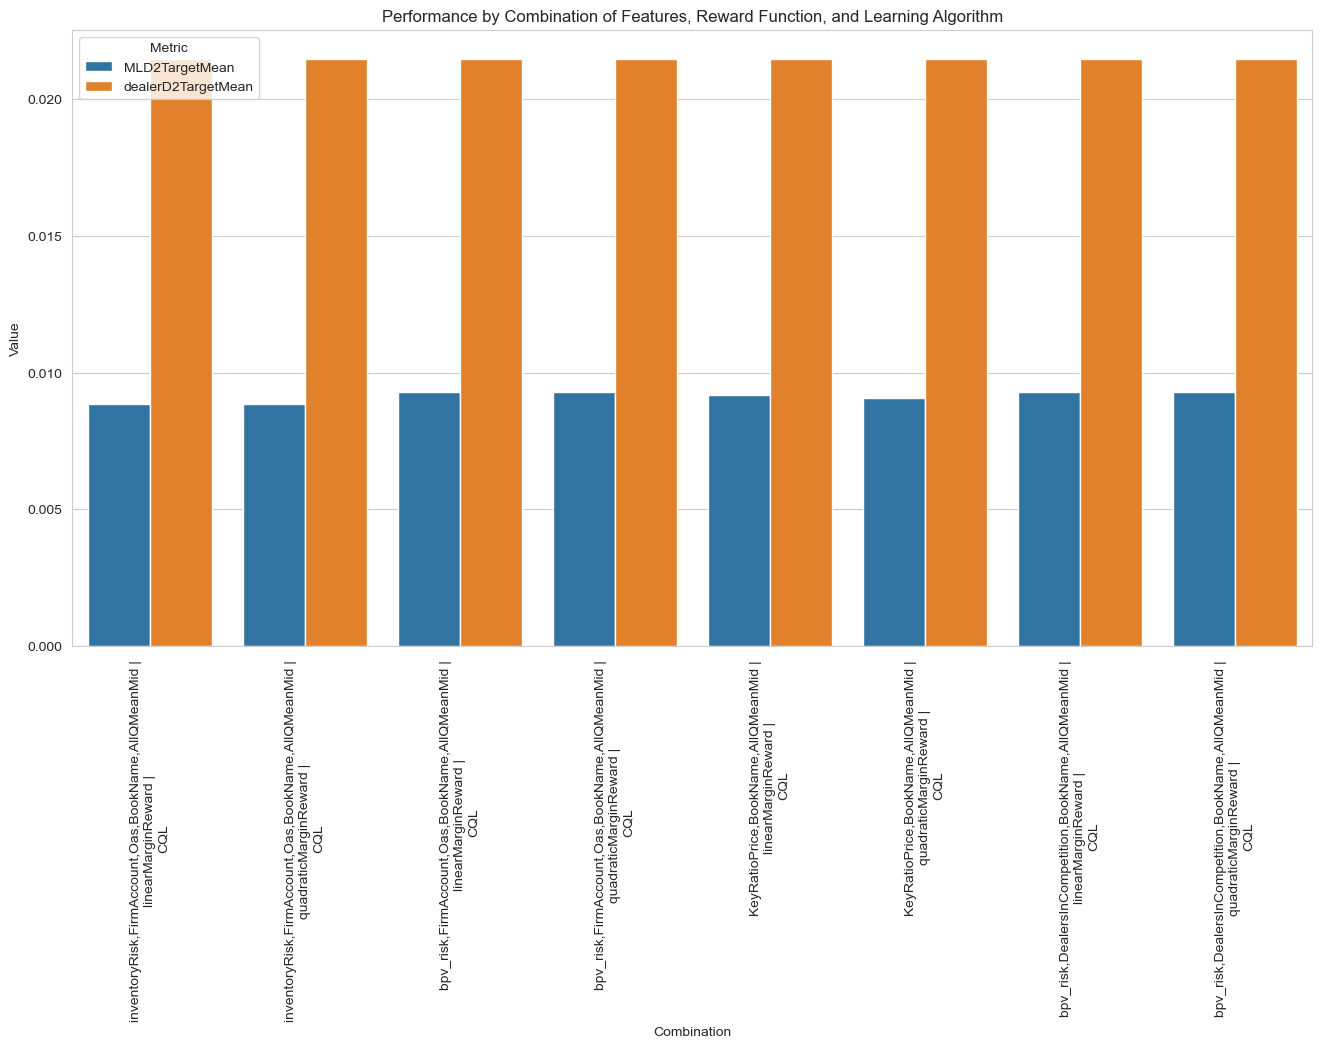

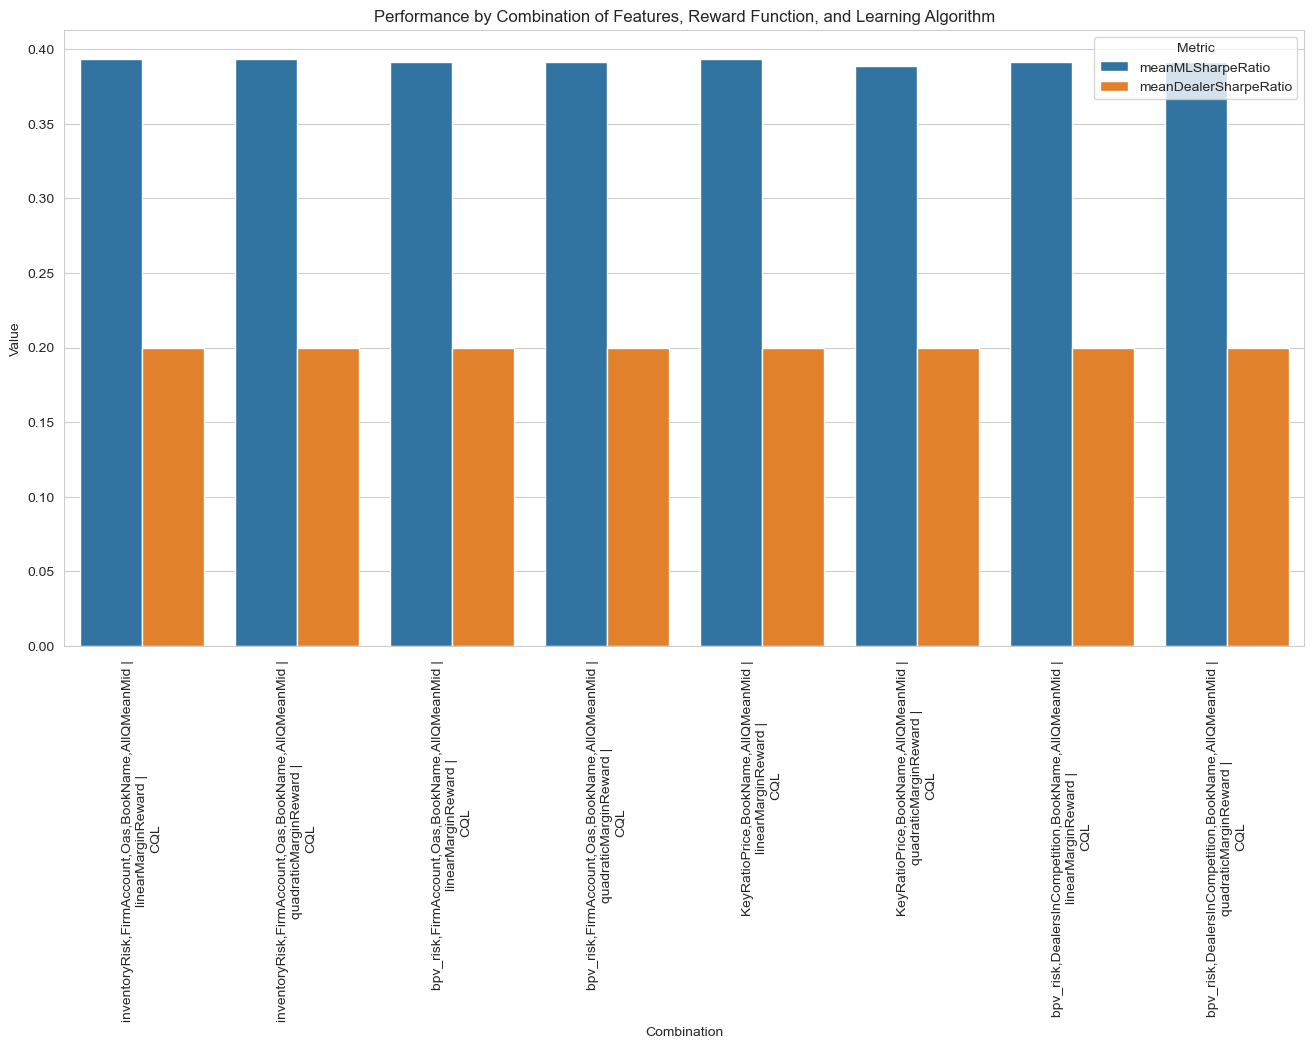

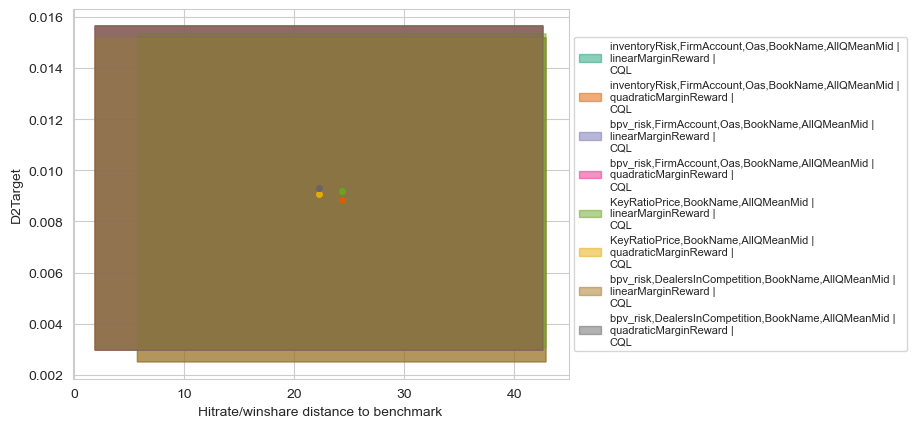

In [4]:
# Read the CSV file into a pandas DataFrame
file_path = "../data/data_inventory_risk.csv"
df = pd.read_csv(file_path,  index_col=0)

# Datetime format
df["TradeTime"] = pd.to_datetime(df["TradeTime"], format="%m/%d/%Y %H:%M:%S")

isinCount = df.Isin.value_counts()
for isin, count in isinCount.head(5).items():
    # Filter the DataFrame for the current ISIN
    df_filtered = df[df.Isin == isin]
    df_filtered.reset_index(drop=True, inplace=True)
   
    #Split into train and test set  
    train_df, test_df = split_data(df_filtered, 0.7)

    #Further split test into val and test, to make model selection
    val_df, test_df = split_data(test_df.copy(), 0.5)

    print(f"Results for ISIN {isin}, counts: {count}")
    train_loop(train_df, val_df)
    print("\n")
